# Sumário

* [1. Introdução](#introducao)
* [2. Configuração do Projeto e Extração dos Dados](#configuracao)
    * [2.1. Importando bibliotecas](#importacao)
    * [2.2. Extração dos Dados (API)](#extracao)
    * [2.3. Carregamento dos Dados](#carregamento)
* [3. Busca Exploratória de Dados](#busca-exploratoria)
    * [3.1. Análise Macroscópica (Descrição dos Dados)](#macro)
    * [3.2. Análise Microscópica (Exploração e Qualidade dos Dados)](#micro)
* [4. Sumário do Tratamento e Qualidade dos Dados](#sumario-qualidade)
* [5. Visualização de Dados (Análise Gráfica)](#visualizacao)
* [6. Conclusão](#conclusao)

# 1. Introdução 

Os candidatos deverão extrair dados da API indicada, realizar tratamento (limpeza, normalização e tipagem), armazenar os dados em um banco de dados relacional e, em seguida, efetuar uma análise quantitativa e qualitativa

<a id='configuracao'></a>
# 2. Configuração do Projeto e Extração dos Dados

<a id='importacao'></a>
## 2.1 Importação

In [1]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display,Markdown
from analise_obras_df.analise import verifica_coluna
from analise_obras_df.analise import sugere_conversao

<a id='extracao'></a>
## 2.2. Extração dos Dados (API)

<a id='13---extracao-e-carregamento-dos-dados-api'></a>


O serviço da API é disponibilizado pela plataforma ObrasGov.br como uma solução tecnológica para a melhoria da governança dos investimentos federais em infraestrutura, por meio do acompanhamento e do monitoramento da execução dos investimentos em projetos de infraestrutura do Governo Federal. A plataforma reúne informações acerca:

- Dados dos projetos de investimentos em infraestrutura;
- Dados dos de georreferenciamento projetos de investimentos em infraestrutura;
- Dados da Execução Física;
- Dados de Execução Financeira;

Para esse projeto, serão utilizados especificamente dados do endpoint "/projeto-investimento", com filtragem focada em informações sobre o Distrito Federal (DF).

Para mais informações relevantes sobre a API acesso disponível em [ObrasGov.br](https://api.obrasgov.gestao.gov.br/obrasgov/api/swagger-ui/index.html#/Projeto%20De%20Investimento/buscarPorFiltro)


No bloco abaixo organiza-se a URL base, endpoint e filtros. Tendo o endereço como base, é feita a requisição (GET).

In [2]:
#URL_BASE = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"
params_request = {
    'uf': "DF",
    'pagina': 0,
    'tamanhoDaPagina': 100,
    'ordenacao': 'ID_UNICO'
}
db_total = []
db_metadados = []
max_retries = 5
count_retries = 0
print(f"Iniciando requisição para API com os parametros: {params_request}")

while True:
    try:
        response = requests.get(URL_BASE, params = params_request)
        print(f"Requisitando dados da url: {response.url}")

        response.raise_for_status()

        pagina = response.json()
        metadados_da_pagina = pagina.copy()
        metadados_da_pagina.pop('content', None)
        db_metadados.append(metadados_da_pagina)

        

        if pagina['content']:
            db_total.extend(pagina['content'])
            print(f"Conteúdo da pagina {params_request['pagina']} coletado com sucesso. Total de obras acumuladas {len(db_total)}")

        else:
            print(f"Nenhum resultado encontrado na pagina {params_request['pagina']}. Extração completa")
            break

        print(f"Atualizando pagina {params_request['pagina']} -> {params_request['pagina']+1}")
        params_request['pagina'] += 1
        count_retries = 0
        time.sleep(20)

    except requests.exceptions.HTTPError as http_erro:
        status_code = http_erro.response.status_code
        count_retries += 1

        if count_retries > max_retries:
            print("Finalizando processo de extraçao por excesso de erros.")
            break

        if status_code == 429:
            time_sleep = 60 * count_retries
            print(f"Servidor retornando erro {status_code} - Muitas requisições. Aguardando {time_sleep} segundos para nova tentativa")
            time.sleep(time_sleep)
            continue
        elif status_code >= 500:
            time_sleep = 60
            print(f"Servidor retornando erro {status_code} - Erro no servidor. Aguardando {time_sleep} segundos para nova tentativa")
            time.sleep(time_sleep)
            continue
        else:
            print(f"Erro HTTP inesperado: {http_erro}. Finalizando processo de extração.")
            break

    except requests.exceptions.RequestException as erro:
        print(f"Ocorreu um erro no processo de requisição: <{erro} >")
        print(f"Processo de extração interrompido na pagina {params_request['pagina']}")
        break

Iniciando requisição para API com os parametros: {'uf': 'DF', 'pagina': 0, 'tamanhoDaPagina': 100, 'ordenacao': 'ID_UNICO'}


NameError: name 'URL_BASE' is not defined

<a id='carregamento'></a>
## 2.3 Carregamento dos Dados

In [2]:
raw_path = "../data/1-raw/"
json_file = "obras_df_raw.json"

meta_path = "../data/1-raw/"
meta_file = "obras_df_metadados.json"

### 2.3.1 Armazemento Inicial (RAW)

 Nesse primeiro momento, os dados recebidos da requisição, serão armazenados em seu estado bruto, sem nenhum tratamento, na pasta 1-raw/

In [ ]:
try:
    with open (raw_path+json_file, 'w', encoding = 'utf-8') as f:
        json.dump(db_total, f, ensure_ascii=False, indent=4)
        display(Markdown((f"Dados brutos armazenados com sucesso. Arquivo: {json_file}")))
        
except Exception as e:
    print(f"Erro ao armazenar dados brutos: <{e}>")


with open (meta_path+meta_file, 'w', encoding = 'utf-8') as f:
    json.dump(db_metadados, f, ensure_ascii=False, indent=4)
    display(Markdown((f"Metadados armazenados com sucesso. Arquivo: {meta_file}")))

Dados brutos armazenados com sucesso. Arquivo: obras_df_raw.json

Metadados armazenados com sucesso. Arquivo: obras_df_metadados.json

### 2.3.2 Carga e Estruturação dos Dados em um DataFrame
Com os dados brutos devidamente armazenados, o próximo bloco é responsável por carregá-los em uma estrutura de dados que nos permita manipulá-los e analisá-los de forma eficiente. Para isso, utilizou-se a biblioteca `pandas` para converter a lista de obras em um **DataFrame**. 

In [3]:
try: 
    with open(raw_path+json_file, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)

    obras_DF = raw_data
    df = pd.DataFrame(obras_DF)

    display(Markdown(("Dados carregados na dataframe com sucesso")))

except FileNotFoundError:
    print("Arquivo não encontrado")

except Exception as e:
    print(f"Erro encontrado: <{e}>")

estilos_alinhamento = [
    # Regra 1: Alinha todos os cabeçalhos (th = table header) à esquerda
    dict(selector="th", props=[("text-align", "left")]),
    
    # Regra 2: Alinha todas as células de dados (td = table data) à esquerda
    dict(selector="td", props=[("text-align", "center")])
]

Dados carregados na dataframe com sucesso

<a id='busca-exploratoria'></a>
# 3. Busca exploratória dos dados

Esse tópico refere-se ao entendimento dos dados e contará com a abordagem descrita pela metodologia [**CRISP-DM**](https://www.datascience-pm.com/crisp-dm-2/) em seu tópico [**II. Data Understanding**](https://www.ibm.com/think/insights/data-quality-metrics). Portanto, após a etapa de coleta inicial dos dados, serão implementados os seguintes processos:
- **Descrição dos Dados**: Nesse momento a database será examinada a fim de trazer suas propriedades superficiais. Métricas de qualidade de dados abordadas:
- **Exploração dos Dados e Verificação da Qualidade dos Dados**: Etapa responsável por uma análise mais profunda, considerando as relações, regras de negócio e contexto aos quais os dados estão inseridos.
  
Para o processo de verificação da qualdiade dos Dados, a database será submetida a verificações, tomando como base as métricas de qualidade apresentadas por documentações disponibilizadas pela **IBM**:
- **Data accuracy**: Data correctly represents real-world events and values.
- **Data completeness**: Data contains all necessary records with no missing values.
- **Data consistency**: Data is coherent and standardized across the organization, ensuring that data records in different datasets are compatible.
- **Data timeliness**: Data values are up to date, allowing organizations to avoid making decisions based on stale information.
- **Data uniqueness**: Data is free from redundancies or duplicate records, which can distort analysis.
- **Data validity**: Data conforms to business rules, such as falling within permitted ranges for certain data values and meeting specified data format standards.

Os processos mencionados acima serão organizados em duas fases principais de análise: **Análise Macroscópica**, a qual contém o processo de **Descriçao dos Dados** e **Análise Microscópica**, que englobará a **Exploração** e **Verificação da Qualidade** dos dados.

<a id='macro'></a>
## 3.1 Análise Macroscópica


### 3.1.1 Dimensões do Dataframe
- **Total de Registros**: 834
- **Total de Colunas**: 31


### 3.1.2 Dicionário de Dados

,tipo,Valores Nulos
dataFinalEfetiva,object,827
dataInicialEfetiva,object,804
observacoesPertinentes,object,709
populacaoBeneficiada,object,670
qdtEmpregosGerados,object,668
descPopulacaoBeneficiada,object,664
naturezaOutras,object,629
descPlanoNacionalPoliticaVinculado,object,558
cep,object,445
endereco,object,406


### 3.1.3 Análise de Completude Geral

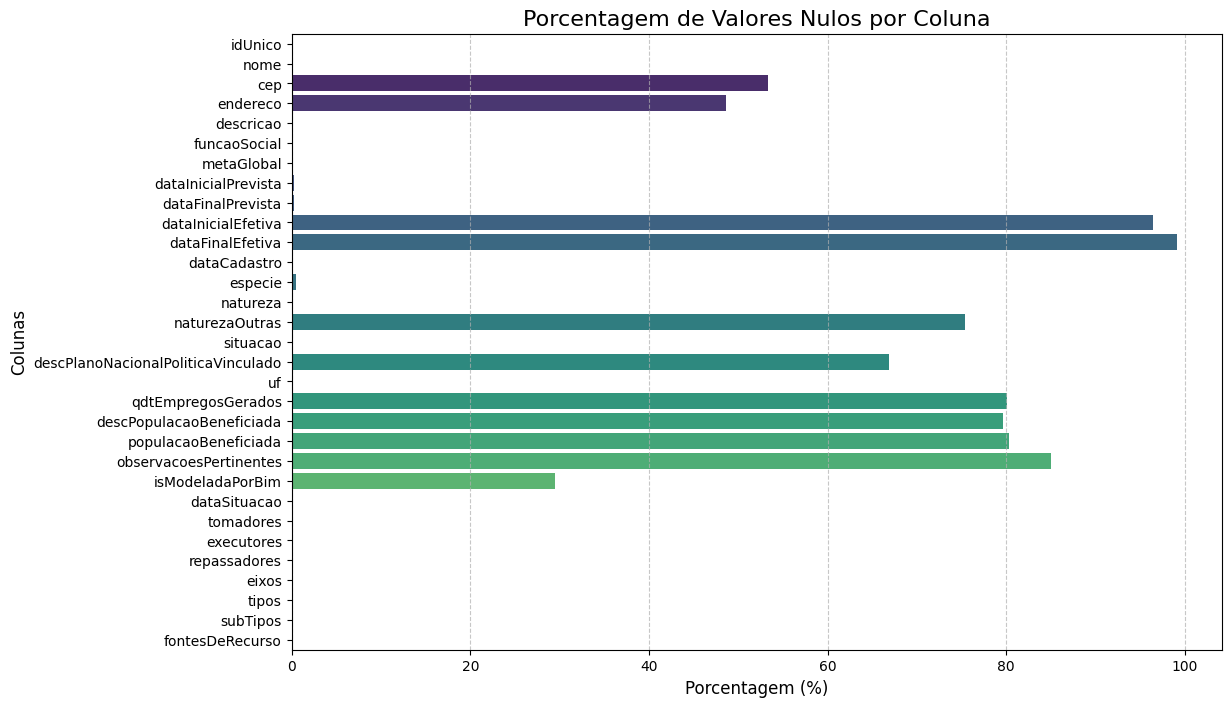

### 3.1.4 Análise de Unicidade Geral

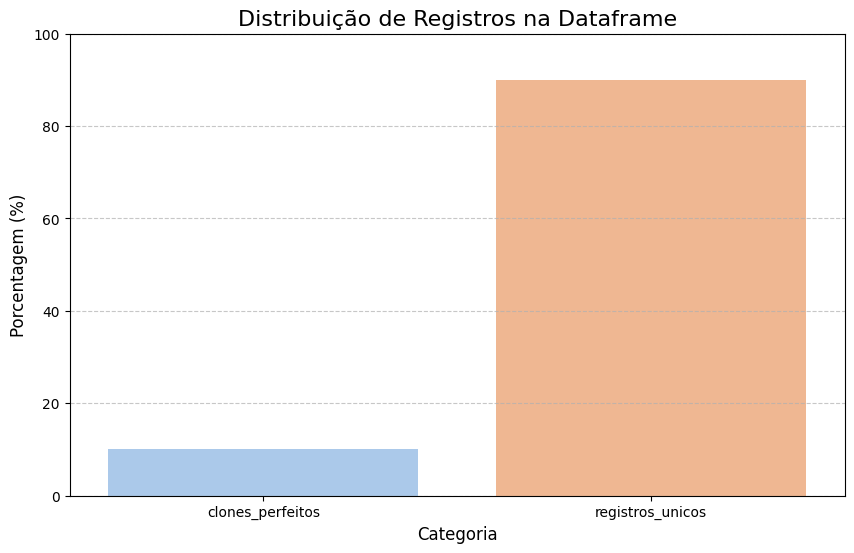

Registros únicos: 750 (89.93%) 

 Registros duplicados: 84 (10.07%)

In [4]:
nulos_por_coluna = {}
df_temp = df.copy()
colunas_unhashble = []
for coluna in df.columns:
    # Verifica colunas com características unhashble
    if df[coluna].apply(lambda x: isinstance(x, (list, dict))).any():
        # Converte a coluna para string para permitir a verificação de duplicatas
        df_temp[coluna] = df_temp[coluna].astype('string')
        colunas_unhashble.append(coluna)
    # Verifica coluna por coluna a quantidade de valores nulos
    nulos_por_coluna[coluna] = df[coluna].isnull().sum()

# Gera nova dataframe sem as linhas que são clones perfeitos
indices_limpos = df_temp.drop_duplicates().index
df_limpa = df.loc[indices_limpos]

# Apresentação dos resultados

dicionario_df = pd.DataFrame(index=df.columns)
dicionario_df['tipo'] = df.dtypes
dicionario_df['Valores Nulos'] = nulos_por_coluna.values()

nulos_series = pd.Series(nulos_por_coluna)
porcentagem_nulos = (nulos_series / len(df)) * 100

distribuicao_df = {}
distribuicao_df['clones_perfeitos'] = (len(df) - len(df_limpa)) / len(df) * 100
distribuicao_df['registros_unicos'] = (len(df_limpa)/ len(df) * 100)

display(Markdown((f"""
### 3.1.1 Dimensões do Dataframe
- **Total de Registros**: {len(df)}
- **Total de Colunas**: {len(df.columns)}
"""
)))
display(Markdown(f"### 3.1.2 Dicionário de Dados"))
display(dicionario_df.sort_values(by='Valores Nulos', ascending=False))


display(Markdown(f"### 3.1.3 Análise de Completude Geral"))
plt.figure(figsize=(12, 8))
sns.barplot(x=porcentagem_nulos.values, y=nulos_series.index, hue=nulos_series.index, orient='h', palette='viridis', legend=False)
plt.title('Porcentagem de Valores Nulos por Coluna', fontsize=16)
plt.xlabel('Porcentagem (%)', fontsize=12)
plt.ylabel('Colunas', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

display(Markdown(f"### 3.1.4 Análise de Unicidade Geral"))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(distribuicao_df.keys()), y=list(distribuicao_df.values()), hue=list(distribuicao_df.keys()), palette='pastel', legend=False)
plt.title('Distribuição de Registros na Dataframe', fontsize=16)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

display(Markdown(f"Registros únicos: {len(df_limpa)} ({distribuicao_df['registros_unicos']:.2f}%) \n\n Registros duplicados: {len(df) - len(df_limpa)} ({distribuicao_df['clones_perfeitos']:.2f}%)"))


A partir dos resultados acima, compreende-se que a estrutura da base de dados contém 31 colunas, demonstrando que há uma riqueza de detalhes sobre as obras. Além disso, há um total de 834 registros de obras relacionados a `uf = DF`.

- Portando a dimensão da base de dados é definida por (linhas,colunas) = (834,31)

Ademais, percebe-se que há colunas específicas com alta `taxa de nulidade´ . Isto posto, tem-se como hipótese inicial que os registros que possuem esses campos nulos se encontram em estágios de desenvolvimento diferente daqueles que os tem preenchidos. 

Acerca da `unicidade geral` da database, foram removidas as tuplas que fossem completamente clones, concluindo a primeira etapa de tratamento dos dados. O total de linhas duplicadas era de `84`, restando assim `750` registros da dataframe limpa.

O último resultado demonstrou que foram atribuídas (pela ferramenta `info()`) a tipagem `object` para a totalidade das colunas. O comportamento não é completamente fora do esperado e sinaliza a necessidade mais crítica de tratamento e conversão dos dados. Para uma primeira análise, superficial, a função sugere_conversão infere a melhor tipagem a se atribuir para cada coluna, embora não gere resultados para colunas com características unhashble.


In [5]:
import warnings
warnings.filterwarnings(
    'ignore', 
    message="Could not infer format, so each element will be parsed individually.*"
)

display(Markdown("#### Sugestões de Tipos de Dados:"))

sugestoes = {coluna: sugere_conversao(df_limpa[coluna]) for coluna in df_limpa.columns}
dataframe_sugestoes = pd.DataFrame.from_dict(sugestoes, orient='index', columns=['Tipo Sugerido'])

display(dataframe_sugestoes)

#### Sugestões de Tipos de Dados:

,Tipo Sugerido
idUnico,string
nome,string
cep,string
endereco,string
descricao,string
funcaoSocial,string
metaGlobal,string
dataInicialPrevista,datetime64[ns]
dataFinalPrevista,datetime64[ns]
dataInicialEfetiva,datetime64[ns]


<a id='micro'></a>
## 3.2 Análise Microscópica

Durante a análise microscópica, a ideia será propor uma narrativa que agrupo as colunas de acordo com suas aparentes funções dentro do contexto da base de dados. Essa decisão é feita pois há colunas que não existem isoladamente, mas sim em grupos lógicos de negócio. A princípio, a ferramenta que foi usada para sugerir a tipagem, será usada como auxílio para essa organização.

### 3.2.1 Análise de Colunas **Identificadoras**

#### 3.2.1.1 Coluna [idUnico]

array(['50379.53-54', '42724.53-27', '19970.53-78', '24797.53-15',
       '24822.53-70', '4541.53-44', '4545.53-03', '4546.53-60',
       '21324.53-75', '21327.53-34'], dtype=object)

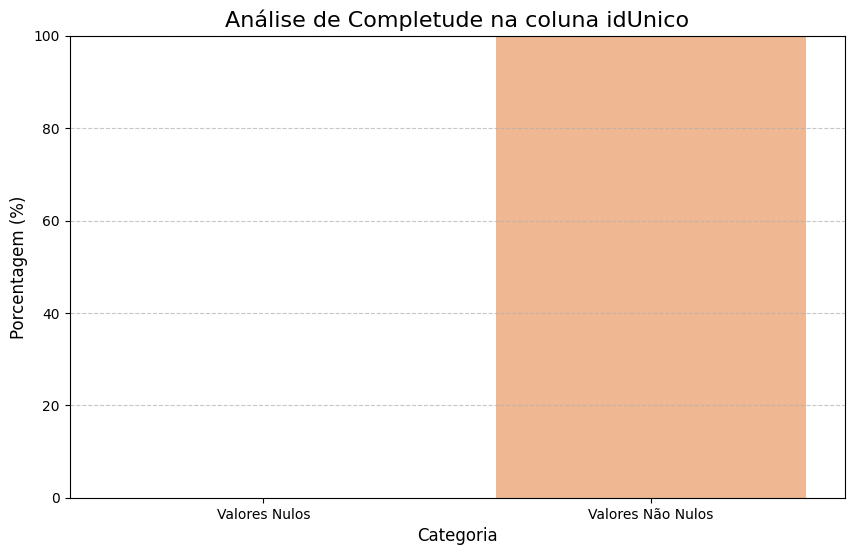

Coluna **idUnico** possui 750 valores preenchidos, correspondendo a 100.00% do total de registros.

Coluna **idUnico** possui 0 valores nulos, correspondendo a 0.00% do total de registros.

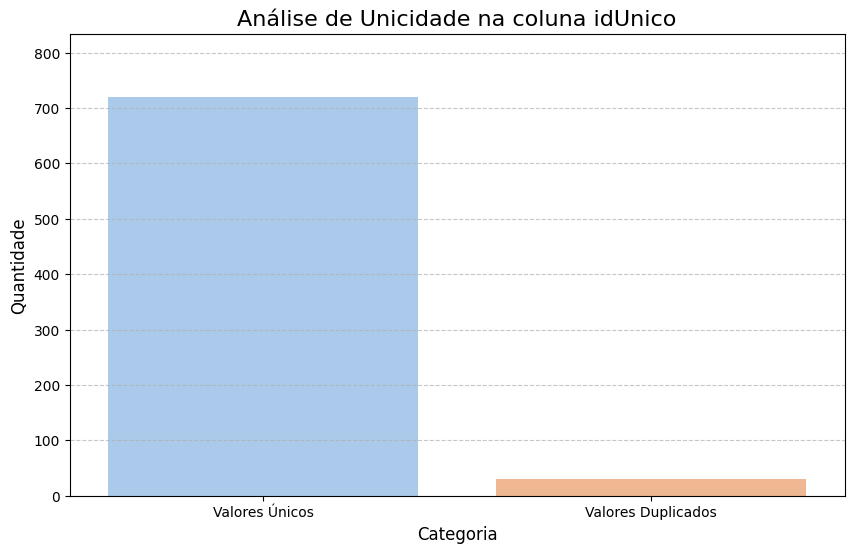

Coluna **idUnico** possui 719 valores únicos, correspondendo a 95.87% do total de registros.

Coluna **idUnico** possui 31 valores duplicados, correspondendo a 4.13% do total de registros.

In [6]:
coluna = 'idUnico'
completude_coluna, unicidade_coluna = verifica_coluna(coluna,df_limpa)
display(df_limpa[coluna].head(10).unique())

plt.figure(figsize=(10, 6))
sns.barplot(x=list(completude_coluna.keys()), y=[(v / len(df_limpa)) * 100 for v in completude_coluna.values()], hue=list(completude_coluna.keys()), palette='pastel', legend=False)
plt.title(f'Análise de Completude na coluna {coluna}', fontsize=16)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(Markdown(f"Coluna **{coluna}** possui {completude_coluna['Valores Não Nulos']} valores preenchidos, correspondendo a {completude_coluna['Valores Não Nulos'] / len(df_limpa) * 100:.2f}% do total de registros."))
display(Markdown(f"Coluna **{coluna}** possui {completude_coluna['Valores Nulos']} valores nulos, correspondendo a {completude_coluna['Valores Nulos'] / len(df_limpa) * 100:.2f}% do total de registros."))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(unicidade_coluna.keys()), y=list(unicidade_coluna.values()), hue=list(unicidade_coluna.keys()), palette='pastel', legend=False)
plt.title(f'Análise de Unicidade na coluna {coluna}', fontsize=16)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, df[coluna].count())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(Markdown(f"Coluna **{coluna}** possui {unicidade_coluna['Valores Únicos']} valores únicos, correspondendo a {unicidade_coluna['Valores Únicos'] / len(df_limpa) * 100:.2f}% do total de registros."))
display(Markdown(f"Coluna **{coluna}** possui {unicidade_coluna['Valores Duplicados']} valores duplicados, correspondendo a {unicidade_coluna['Valores Duplicados'] / len(df_limpa) * 100:.2f}% do total de registros."))

O primeiro resultado interessante que pode-se analizar, é que a partir do padrão dos 10 primeiros valores preenchidos nessa coluna, é possivel declarar que a melhor tipagem a se atribuir  é de fato `string`. O motivo para essa conclusão, é o fato de haver uma mesclagem entre caracteres alfanuméricos.

Após verificado o aspecto tipagem da coluna, a partir dos resultados é viável fazer mais algumas inferências sobre os dados. Os resultados demonstram que a coluna `idUnica` não assume completamente o papel de idenficador dentro da database, como presumia-se a princípio. Enquanto a coluna possui seus valores preenchidos integralmente, com uma taxa de nulidade equivalente a 0%, há um fato curioso que merece atenção:

-  **Resultado**: `Quantidade de valores duplicados na coluna [idUnico]: 31`

Todas os registros completamente clonados foram retirados para uma análise mais limpa, porém ainda sim há valores duplicados na coluna `idUnico`. Isto posto, há uma possivel anomalia na coluna que requer uma análise mais profunda. Portanto, primeiro será feita a conversão do tipo `object` para `string`. Após isso, mais alguns processos investigativos serão feitos com o objetivo de determinar o perfil dessas duplicatas e o padrão do campo `idUnico`.

In [7]:
# Conversão object -> string:
df_limpa['idUnico'] = df_limpa['idUnico'].astype('string')
print(f"Sucesso. Nova tipagem atribuída para a tabela [idUnico]: {df['idUnico'].dtype}")

contagem_padrao = df_limpa['idUnico'].str.contains('.53').sum()
porcentagem_padrao = (contagem_padrao / len(df_limpa)) * 100
display(Markdown(f"A coluna **idUnico** possui {contagem_padrao} registros que contém o padrão '.53', correspondendo a {porcentagem_padrao:.2f}% do total de registros."))

padrao_espaco_brancos = df_limpa['idUnico'].str.strip() != df_limpa['idUnico']
if padrao_espaco_brancos.any():
    count_espaco_brancos = padrao_espaco_brancos.sum()
    porcentagem_espaco_brancos = (count_espaco_brancos / len(df_limpa)) * 100
    display(Markdown(f"A coluna **idUnico** possui {count_espaco_brancos} registros com espaços em branco no início ou fim, correspondendo a {porcentagem_espaco_brancos:.2f}% do total de registros."))
else:
    display(Markdown(f"A coluna **idUnico** não possui registros com espaços em branco no início ou fim."))

# Verificação de duplicatas:
display((df_limpa[df_limpa['idUnico'].duplicated(keep=False)]['idUnico'].value_counts()).unique())
print(f"Frequência em que os casos de duplicatas ocorrem:\n {df_limpa[df_limpa['idUnico'].duplicated(keep=False)]['idUnico'].value_counts().value_counts()}")
display(df_limpa['idUnico'].duplicated(keep=False).value_counts())


Sucesso. Nova tipagem atribuída para a tabela [idUnico]: object


A coluna **idUnico** possui 746 registros que contém o padrão '.53', correspondendo a 99.47% do total de registros.

A coluna **idUnico** não possui registros com espaços em branco no início ou fim.

<IntegerArray>
[2]
Length: 1, dtype: Int64

Frequência em que os casos de duplicatas ocorrem:
 count
2    31
Name: count, dtype: Int64


idUnico
False    688
True      62
Name: count, dtype: int64

 O ultimo resultado trouxe mais algumas informações importantes acerca do perfil da coluna idUnico. Em síntese, tem-se que:
 - **Escala Original**: Foram identificados `31` idUnico distintos que possuem valores duplicados.
 - **Escala Total**: Ao total, indentificou-se `62` valores envolvidos nos casos de duplicatas (**Originais**: `31`, **Duplicatas**: `31`)
 - **Padrão dos Casos de Repetição**: Dentre os casos de duplicatas, descobriu-se que os valores de `idUnico` se repetem apenas `1` vez. Observa-se a proporção de 1:1.

Diante disso, sabe-se que muito provavelmente esses valores indicam algo sobre os padrões e regras de negócio aplicadas a database. Portanto, para encontrar mais detalhes sobre o contexto, o próximo passo é comparar paralelamente os registros duplicados, a fim de encontrar os campos modificados.

In [8]:
grupo_id_duplicados = (df_limpa[df_limpa['idUnico'].duplicated(keep=False)]).groupby('idUnico')
resumo_diference = []
for id_unico, grupo in grupo_id_duplicados:
    diference = grupo.iloc[0] != grupo.iloc[1]
    resumo_diference.append(diference)

df_resumo_diference = pd.DataFrame(resumo_diference)
display(pd.DataFrame(df_resumo_diference.sum()))

,0
idUnico,0
nome,0
cep,19
endereco,18
descricao,0
funcaoSocial,0
metaGlobal,0
dataInicialPrevista,0
dataFinalPrevista,0
dataInicialEfetiva,29


Os resultados acima apresentam informações sobre quantas vezes cada coluna foi modificada entre os 31 casos de duplicatas. 

No casos de clonagem da coluna `idUnico`, tem-se o registro original e o registro posterior, formando um par. Assim, levando em consideração os resultados coletados até o momento, é factível realizar a seguinte inferência:

- A primeira ocorrência de um idUnico representa o cadastro inicial, contendo as informações básicas da obra. A segunda ocorrência, que é criada utilizando o mesmo idUnico, funciona como uma atualização de status ou um registro de conclusão da obra. Os campos que contém a maior frequência de modificação durante esse processo são:
  
  - DataInicialEfetiva
  - DataFinalEfetiva
  - descPlanoNacionalPoliticaVinculado
  - qtdEmpregosGerados
  - descPopulacaoBeneficiada
  - observacoesPertinentes
  - subTipos

O fato de ser criado um novo registro para atualização dos dados, ao invés de aplicar as mudanças nas tuplas originárias demonstra o motivo de alta taxa de nulidade em algumas colunas da database, além de afirmar a suspeita inicial de que os dados se encontram em estágios de vida diferentes.



**Análise Qualitativa Coluna [idUnico]**:
- Completude esta excelente, ao apresentar 100% dos campos preeenchidos.
- Unicidade da coluna não pode deixar de ser considerada adequada, contando com 95% de valores únicos, embora ainda existam poucos valores duplicados.
- A validade da coluna demonstra ser adequada, considerando que os registros seguem o formato recorrente (`INT`**.**`INT`**-**`INT`) e demonstram relação no contexto de negócio, ao tomar como base que 99.47% dos registros, possuem o seguinte padrão: `INT`.53-`INT`. Fator que provavelmente refere-se a UF = **DF**. Ademais, verificou-se que os registros dessa coluna não apresentavam elementos vazios que pudessem apresentar efeitos fantasmas em análises posteriores.

#### 3.2.1.2 Coluna [nome]

array(['DL - 304/2024 - Contratação de instituição para execução de serviços técnico-especializados para realização de atualizações no Método de Dimensionamento de Pavimentos Rígidos do DNI',
       'Escola Classe Crixá São Sebastião',
       'Reajuste do Contrato 45/2021 - Contrução do Centro de Formação e Aperfeiçoamento de Praças - CEFAP do CBMDF',
       'Implantação de Passarelas nas Estradas Parque do DF',
       'obra de construção da  Cabine de Medição, localizado no Setor Central do Campus Universitário Darcy Ribeiro, da Universidade de Brasília, em Brasília/DF',
       '202111-22-Ronald 1', 'Reforma Viveiro Agroecologia',
       'Reforma Agroecologia'], dtype=object)

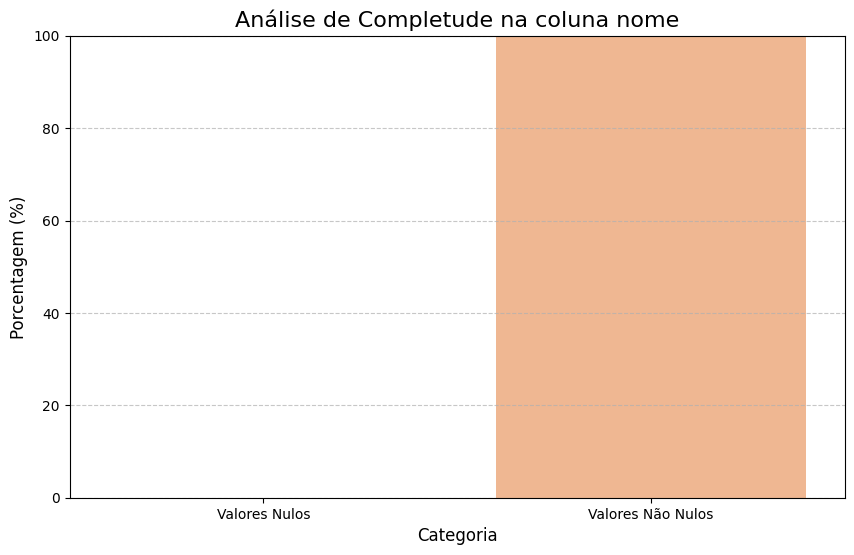

Coluna **nome** possui 750 valores preenchidos, correspondendo a 100.00% do total de registros.

Coluna **nome** possui 0 valores nulos, correspondendo a 0.00% do total de registros.

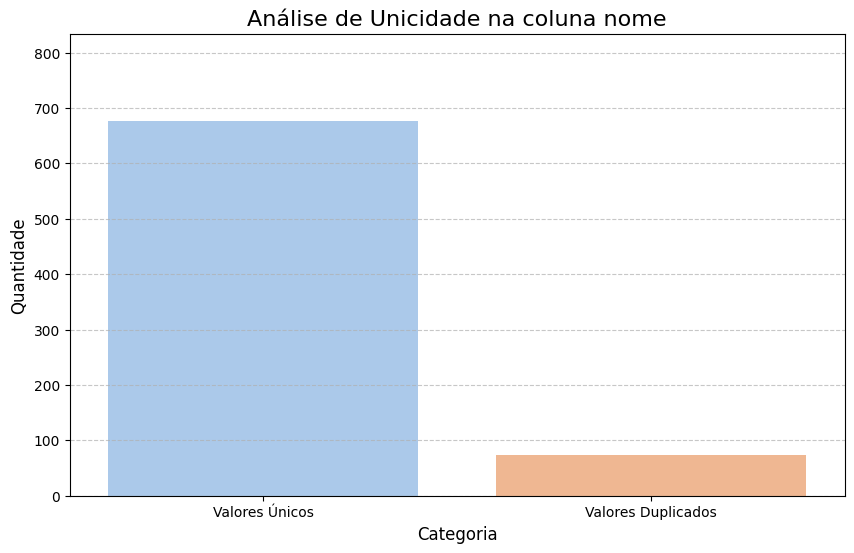

Coluna **nome** possui 676 valores únicos, correspondendo a 90.13% do total de registros.

Coluna **nome** possui 74 valores duplicados, correspondendo a 9.87% do total de registros.

In [9]:
coluna = 'nome'
completude_coluna, unicidade_coluna = verifica_coluna(coluna,df_limpa)
display(df_limpa[coluna].head(10).unique())

plt.figure(figsize=(10, 6))
sns.barplot(x=list(completude_coluna.keys()), y=[(v / len(df_limpa)) * 100 for v in completude_coluna.values()], hue=list(completude_coluna.keys()), palette='pastel', legend=False)
plt.title(f'Análise de Completude na coluna {coluna}', fontsize=16)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(Markdown(f"Coluna **{coluna}** possui {completude_coluna['Valores Não Nulos']} valores preenchidos, correspondendo a {completude_coluna['Valores Não Nulos'] / len(df_limpa) * 100:.2f}% do total de registros."))
display(Markdown(f"Coluna **{coluna}** possui {completude_coluna['Valores Nulos']} valores nulos, correspondendo a {completude_coluna['Valores Nulos'] / len(df_limpa) * 100:.2f}% do total de registros."))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(unicidade_coluna.keys()), y=list(unicidade_coluna.values()), hue=list(unicidade_coluna.keys()), palette='pastel', legend=False)
plt.title(f'Análise de Unicidade na coluna {coluna}', fontsize=16)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, df[coluna].count())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(Markdown(f"Coluna **{coluna}** possui {unicidade_coluna['Valores Únicos']} valores únicos, correspondendo a {unicidade_coluna['Valores Únicos'] / len(df_limpa) * 100:.2f}% do total de registros."))
display(Markdown(f"Coluna **{coluna}** possui {unicidade_coluna['Valores Duplicados']} valores duplicados, correspondendo a {unicidade_coluna['Valores Duplicados'] / len(df_limpa) * 100:.2f}% do total de registros."))

A coluna nome apresenta alta integridade, com `100%` de preenchimento (nenhum valor nulo). A natureza textual dos dados, com descrições livres e não categóricas, confirma que string é o tipo de dado mais apropriado.

A análise de unicidade revelou que, embora `90.13%` dos valores sejam únicos, existem `74` ocorrências duplicadas. Embora a taxa de duplicagem pareça pequena, dada porcentagem inferior a `10%`, este número é notável, pois é superior (~2x) às `31` duplicatas parciais encontradas na coluna idUnico. Isso indica que ha registros de obras com IDs diferentes que compartilham o mesmo nome. Esse fato é contra-intuitivo, considerando que o campo nome é livre de padrões e formatos, o que teoricamente tornaria mais difícil encontrar valores exatamente iguais.

Observado esse comportamento anômalo, o proximo bloco verifica os nomes que apresentam repetição acima de 2, considerando que aqueles com repetiçao de exatamente 2 se encontram inseridos na proporcionalidade apontada pela análise da coluna de idUnico.

In [10]:
df_limpa['nome'] = df_limpa['nome'].astype('string')

# Apresenta os nomes que mais se repetem
contagem_nomes = df_limpa['nome'].value_counts()
nomes_duplicados = contagem_nomes[contagem_nomes > 2]
display(Markdown("##### Nomes de obras que mais se repetem:"))
display(pd.DataFrame(nomes_duplicados.head(10)).style.set_table_styles(estilos_alinhamento))

##### Nomes de obras que mais se repetem:

,count
nome,
202111-22-Ronald 1,8
PNCV,6
CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,5
Obra de Desenvolvimento de Teste da Websis - Fabrica de Software - MDRR,5
CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA EM SAÚDE,5
00 00377/2020,4
Implantação de passarelas em estrutura mista nas rodovias do Sistema Rodoviária do Distrito Federal - SRDF,4
Novo PAC - Espaços Esportivos Comunitários no Distrito Federal.,3
SISEG - Sistema integrado de segurança,3


In [11]:
obra_generica = '202111-22-Ronald 1'
display(df_limpa[df_limpa['nome'] == obra_generica])

obra_generica = '00 00377/2020'
display(df_limpa[df_limpa['nome'] == obra_generica])

obra_generica = 'CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA EM SAÚDE'
display(df_limpa[df_limpa['nome'] == obra_generica])

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,...,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
5,4541.53-44,202111-22-Ronald 1,70067-901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,None,...,None,None,2021-11-17,[{'nome': 'FUND.UNIVERSIDADE FEDERAL VALE SAO ...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 45, 'descricao': 'Desenvolvimento', 'i...","[{'id': 38, 'descricao': 'Saneamento', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
6,4545.53-03,202111-22-Ronald 1,70067-901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,None,...,None,None,2021-11-17,[{'nome': 'FUND.UNIVERSIDADE FEDERAL VALE SAO ...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 45, 'descricao': 'Desenvolvimento', 'i...","[{'id': 38, 'descricao': 'Saneamento', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
7,4546.53-60,202111-22-Ronald 1,70067-902,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,None,...,None,None,2021-11-17,[{'nome': 'FUND.UNIVERSIDADE FEDERAL VALE SAO ...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 45, 'descricao': 'Desenvolvimento', 'i...","[{'id': 38, 'descricao': 'Saneamento', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
22,4539.53-84,202111-22-Ronald 1,70067-901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,None,...,None,None,2021-11-17,[{'nome': 'FUND.UNIVERSIDADE FEDERAL VALE SAO ...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 45, 'descricao': 'Desenvolvimento', 'i...","[{'id': 38, 'descricao': 'Saneamento', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
179,4543.53-79,202111-22-Ronald 1,70067-901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,None,...,None,None,2021-11-17,[{'nome': 'FUND.UNIVERSIDADE FEDERAL VALE SAO ...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 45, 'descricao': 'Desenvolvimento', 'i...","[{'id': 38, 'descricao': 'Saneamento', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
180,4540.53-87,202111-22-Ronald 1,70067-901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,None,...,None,None,2021-11-17,[{'nome': 'FUND.UNIVERSIDADE FEDERAL VALE SAO ...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,[{'nome': 'MINISTÉRIO DA INTEGRAÇÃO E DO DESEN...,"[{'id': 4, 'descricao': 'Social'}]","[{'id': 45, 'descricao': 'Desenvolvimento', 'i...","[{'id': 38, 'descricao': 'Saneamento', 'idTipo...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
181,4542.53-01,202111-22-Ronald 1,70067-901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Globa

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,...,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
48,1463.53-66,00 00377/2020,70040-902,BR-010,contratação de empresa especializada para pres...,Preservar vidas e promover o desenvolvimento s...,Gerenciamento de 0 km.,None,None,None,...,None,None,2021-04-26,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
299,1162.53-51,00 00377/2020,70040-902,BR-010,contrataÃ§Ã£o de empresa especializada para pr...,Preservar vidas e promover o desenvolvimento s...,Gerenciamento de 0 km.,2020-06-25,2023-12-21,None,...,None,None,2021-04-26,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
314,6008.53-77,00 00377/2020,70040-902,BR-010,contrataÃ§Ã£o de empresa especializada para pr...,Preservar vidas e promover o desenvolvimento s...,Gerenciamento de 0 km.,2020-06-25,2023-12-21,None,...,None,None,2022-05-10,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
820,1378.53-71,00 00377/2020,70040-902,BR-010,contrataÃ§Ã£o de empresa especializada para pr...,Preservar vidas e promover o desenvolvimento s...,Supervisão de 0 km.,2020-06-25,2024-09-16,None,...,None,None,2025-08-05,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[{'nome': 'DEPARTAMENTO NACIONAL DE INFRAESTRU...,[],"[{'id': 3, 'descricao': 'Econômico'}]","[{'id': 25, 'descricao': 'Rodovia', 'idEixo': 3}]","[{'id': 4, 'descricao': 'Acessos Terrestres', ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,...,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
264,53528.53-75,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,72225-270,QUADRA QNN 27,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,2024-05-06,2024-05-06,None,...,None,None,2025-04-23,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,"[{'nome': 'FUNDO NACIONAL DE SAUDE', 'codigo':...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 39, 'descricao': 'Saúde', 'idEixo': 4}]","[{'id': 78, 'descricao': 'CAPS', 'idTipo': 6}]","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
303,53528.53-75,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,72225-270,QUADRA QNN 27,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,2024-05-06,2024-05-06,None,...,None,None,2025-04-23,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,"[{'nome': 'FUNDO NACIONAL DE SAUDE', 'codigo':...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 39, 'descricao': 'Saúde', 'idEixo': 4}]","[{'id': 78, 'descricao': 'CAPS', 'idTipo': 39}]","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
327,46882.53-02,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,71100-150,QUADRA EPTG QE 4,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,2024-05-06,2024-05-07,None,...,None,None,2024-12-09,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,"[{'nome': 'FUNDO NACIONAL DE SAUDE', 'codigo':...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 39, 'descricao': 'Saúde', 'idEixo': 4}]","[{'id': 78, 'descricao': 'CAPS', 'idTipo': 39}]","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
469,43192.53-05,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,72445-070,QUADRA 7,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,2017-04-07,2017-10-19,None,...,None,None,2024-09-16,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,"[{'nome': 'FUNDO NACIONAL DE SAUDE', 'codigo':...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 39, 'descricao': 'Saúde', 'idEixo': 4}]","[{'id': 78, 'descricao': 'CAPS', 'idTipo': 39}]","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
574,43191.53-59,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,72600-500,SETOR HOSPITALAR,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,2017-03-29,2017-10-19,None,...,None,None,2024-09-16,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,[{'nome': 'FUNDO DE SAUDE DO DISTRITO FEDERAL'...,"[{'nome': 'FUNDO NACIONAL DE SAUDE', 'codigo':...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 39, 'descricao': 'Saúde', 'idEixo': 4}]","[{'id': 78, 'descricao': 'CAPS', 'idTipo': 39}]","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


Após essas análises mais profundas para entender a natureza dos nomes duplicados, revelou-se que, o que antes se apresentava aparentemente como um problema único de duplicagem, na realidade se enquadra em três categorias diferentes:
-  1° Categoria: Dados de teste:
    - Foram localizados 8 registros com nomes muito provavelmente associados a dados de teste ('202111-22-Ronald 1'). Essa conclusão foi alcançada ao notar que os registros contêm valores extremamente genéricos (ex: endereco	 descricao	 funcaoSocial	metaGlobal), inconssistentes (ex: dataInicialPrevista	dataFinalPrevista) e que não representam obras reais. Portanto, esses registros devem ser removidos, pois afetam a qualidade **Data accuracy** da base de dados.

- 2° Categoria: Projetos Relacionados:
    - A segunda categoria refere-se a projetos que estão inseridos em contextos maiores. Embora possuam nomes equivalentes, não são completamente iguais, apresentando valores distintos em colunas-chave (idUnico, metaGlobal, dataFinalPrevista e dataSituacao). Portanto, esses registros não demonstram falta de qualidade na base de dados.

-  3° Categoria: Nomes Categóricos:
   -  A maioria restante das duplicatas (incluindo 'PNCV', 'SISEG', etc.) se enquadra na categoria de nomes genéricos para projetos-padrão. Portanto, essas duplicatas são válidas e apenas refletem a regras de n a nomenclatura padronizada de programas governamentais.

In [12]:
# Remoção dos registros de teste
df_limpa = df_limpa[df_limpa['nome'] != '202111-22-Ronald 1']

### 3.2.2 Análise de Colunas **Textuais**

In [56]:
colunas_textuais = ["cep", "endereco", "descricao", "funcaoSocial", "metaGlobal","naturezaOutras", "descPlanoNacionalPoliticaVinculado", "qdtEmpregosGerados","descPopulacaoBeneficiada","populacaoBeneficiada"]
dicionario_colunas_textuais = {}

for coluna in colunas_textuais:
    display(Markdown(f"#### Resultados da coluna: **{coluna}**"))

    display(pd.DataFrame(df_limpa[coluna].value_counts().head(10)).style.set_table_styles(estilos_alinhamento))

    completude_coluna, unicidade_coluna = verifica_coluna(coluna,df_limpa)

    taxa_leading = df_limpa[coluna].astype(str).str.strip() != df_limpa[coluna].astype(str)
    taxa_leading_sum = taxa_leading.sum()
    
    dicionario_colunas_textuais[coluna] = { "Valores Preenchidos": f"{completude_coluna['Valores Não Nulos']/len(df_limpa) * 100:.2f}% ({completude_coluna['Valores Não Nulos']})", 
                                            "Valores Nulos": f"{completude_coluna['Valores Nulos']/len(df_limpa) * 100:.2f}% ({completude_coluna['Valores Nulos']})",
                                            "Valores Únicos": f"{unicidade_coluna['Valores Únicos']/len(df_limpa) * 100:.2f}% ({unicidade_coluna['Valores Únicos']})",
                                            "Valores Duplicados": f"{unicidade_coluna['Valores Duplicados']/len(df_limpa) * 100:.2f}% ({unicidade_coluna['Valores Duplicados']})",
                                            "taxa_leading": f"{taxa_leading_sum / len(df_limpa) * 100:.2f}% ({taxa_leading_sum})"}

display(Markdown(f"#### **Tabela Resumo - Análise das Colunas Textuais**"))
df_colunas_textuais = pd.DataFrame.from_dict(dicionario_colunas_textuais, orient='index')
display(df_colunas_textuais.style.set_table_styles(estilos_alinhamento))
display(Markdown(f"---"))

#### Resultados da coluna: **cep**

,count
cep,
70040-902,30
71.607-900,14
70.297-400,12
70.770-917,9
73.380-900,8
70.610-200,6
72.429-005,6
70.150-900,6
70067-901,6


#### Resultados da coluna: **endereco**

,count
endereco,
BR-010,12
"Rodovia DF – 128, km 21, Zona Rural de Planaltina",6
"Área Especial 2, S/N, Bairro São Bartolomeu - São Sebastião/DF",6
Área Militar do Aeroporto Internacional de Brasília - Lago Sul,6
"Parque Estação Biológica, PqEB, Av. W5 Norte (final) Caixa Postal 02372 – Brasília, DF",6
"Rodovia DF-460 - Subcentro Leste, Complexo Boca da Mata, Lote 01, Samambaia/ DF",4
HFAB - Hospital de Força Aérea de Brasília - Endereço: Área Militar do Aeroporto Internacional de Brasília - Lago Sul,4
"Esplanada dos Ministérios, Bloco E, S N - Zona Cívico-Administrativa, sala 612",3
BR-080,3


#### Resultados da coluna: **descricao**

,count
descricao,
CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA EM SAÚDE,6
CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,5
"Contratação, por meio de Pregão Eletrônico, de empresa especializada ou consórcio de empresas para execução dos serviços de disponibilização, instalação, operação e manutenção de equipamentos eletrônicos de controle de tráfego nas rodovias federais sob circunscrição do Departamento Nacional de Infraestrutura de Transporte – DNIT.",5
Restauração e reconstrução de pavimento.,4
Projeto de desenvolvimento do MDR para integrar com api do CIPI.R,4
"Construção do Espaço Esportivo Comunitário, em Brasília/DF (Novo PAC)",4
"implantação dos sistemas de monitoramento por câmeras digitais IP e alarmes de intrusão, nos prédios do Banco Central do Brasil, além da integração entre tais sistemas por meio do fornecimento de software de gerenciamento de vídeo, bem como a infraestrutura quando necessária",3
"contrataÃ§Ã£o de empresa especializada para prestaÃ§Ã£o dos serviÃ§os de gerenciamento dos empreendimentos de construÃ§Ã£o, sob a jurisdiÃ§Ã£o do dnit, para toda a malha rodoviÃ¡ria federal da regiÃ£o nordeste.",3
"Prestação de serviços comum de engenharia para a execução de reforma e ampliação da praça de convivência no espaço localizado entre o bloco “G” e “H”, em complemento a a instalação existente com ampliação de calçadas, colocação de bancos e construção de cobertura na passagem que liga o Bloco H a praça Duque de Caxias no QGEX, com fornecimento de equipamentos, materiais e mão-de-obra,",3


#### Resultados da coluna: **funcaoSocial**

,count
funcaoSocial,
SEGURANÇA PÚBLICA,45
"PRESERVAR VIDAS E PROMOVER O DESENVOLVIMENTO SUSTENTÃ¡VEL DO PAÃ­S PRIORIZANDO A SEGURANÃ§A, AS BOAS CONDIÃ§ÃΜES DE TRAFEGABILIDADE E A OTIMIZAÃ§Ã£O DA LOGÃ­STICA DOS TRANSPORTES, ELEVANDO ASSIM O NÃ­VEL DE SERVIÃ§O DAS VIAS.",27
AMPLIAÇÃO DA CAPACIDADE DE TRAFEGO VISANDO A MELHORIA DA SEGURANÇA DO USUÁRIO,23
"VIABILIZAR SOLUÇÕES DE PESQUISA, DESENVOLVIMENTO E INOVAÇÃO PARA A SUSTENTABILIDADE DA AGRICULTURA, EM BENEFÍCIO DA SOCIEDADE BRASILEIRA.",18
AMPLIAÇÃO DA CAPACIDADE DE TRAFEGO VISANDO A MELHORIA DA SEGURANÇA DO USUÁRIO.,16
PRESERVAÇÃO DO PAVIMENTO DAS RODOVIAS E CONSEQUENTE REDUÇÃO NO CUSTO DE MANUTENÇÃO.,10
ESTABELECIMENTO DESTINADO A EDUCAÇÃO TÉCNICO PROFISSIONALIZANTE.,9
"PRESERVAR VIDAS E PROMOVER O DESENVOLVIMENTO SUSTENTÁVEL DO PAÍS PRIORIZANDO A SEGURANÇA, AS BOAS CONDIÇÕES DE TRAFEGABILIDADE E A OTIMIZAÇÃO DA LOGÍSTICA DOS TRANSPORTES, ELEVANDO ASSIM O NÍVEL DE SERVIÇO DAS VIAS.",5
"FISCALIZAÇÃO DO EXCESSO DE VELOCIDADE NAS RODOVIAS E O CONTROLE DE TRÁFEGO E COM ISSO, PROMOVER A EDUCAÇÃO NO TRÂNSITO.",5


#### Resultados da coluna: **metaGlobal**

,count
metaGlobal,
ESCOLA DE EDUCAÇÃO INFANTIL TIPO B,54
PROJETOS BÁSICOS E EXECUTIVOS DE ENGENHARIA,34
"AUMENTAR A OFERTA DE CURSOS TÉCNICOS/TECNOLÓGICOS E DE CURTA DURAÇÃO, E PARA ISSO, NECESSITA AUMENTAR SUA ÁREA PARA LABORATÓRIOS E SALAS DE AULAS INTEGRADAS A ESSES LABORATÓRIOS.",25
CRECHE PRÉ-ESCOLA - TIPO 1,22
COBERTURA DE QUADRA ESCOLAR PEQUENA,18
SUPERVISÃO DE 0 KM.,10
PRESERVAÇÃO DO PAVIMENTO DAS RODOVIAS E CONSEQUENTE REDUÇÃO NO CUSTO DE MANUTENÇÃO.,9
CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA EM SAÚDE,6
CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,5


#### Resultados da coluna: **naturezaOutras**

,count
naturezaOutras,
OUTROS,7
CONSULTORIA,5
"SERVIÇOS DE DISPONIBILIZAÇÃO, INSTALAÇÃO, OPERAÇÃO E MANUTENÇÃO DE EQUIPAMENTOS ELETRÔNICOS DE CONTROLE DE TRÁFEGO NAS RODOVIAS FEDERAIS",5
COMPENSAÇÃO AMBIENTAL,3
SERVICO,2
CONSULTORIA/SERVIÇO,2
SERVIÇOS TÉCNICOS ESPECIALIZADOS,2
PINTURA FORRO DE GESSO BAVOP,1
VDR,1


#### Resultados da coluna: **descPlanoNacionalPoliticaVinculado**

,count
descPlanoNacionalPoliticaVinculado,
OBRAS 2,103
"TRIPLICAR AS MATRÍCULAS DA EDUCAÇÃO PROFISSIONAL TÉCNICA DE NÍVEL MÉDIO, ASSEGURANDO A QUALIDADE DA OFERTA E PELO MENOS 50% (CINQUENTA POR CENTO) DA EXPANSÃO NO SEGMENTO PÚBLICO",30
PLANO DE OBRAS DA POLÍCIA FEDERAL,29
"TRIPLICAR AS MATRÍCULAS DA EDUCAÇÃO PROFISSIONAL TÉCNICA DE NÍVEL MÉDIO, ASSEGURANDO A QUALIDADE DA OFERTA E PELO MENOS 50% (CINQUENTA POR CENTO) DA EXPANSÃO NO SEGMENTO PÚBLICO",6
"PLANO DE OBRAS 2021 DA UNIVERSIDADE DE BRASÍLIA, APROVADO NA 405ª REUNIÃO DO CAD POR MEIO DA RESOLUÇÃO DO CONSELHO DE ADMINISTRAÇÃO Nº 0032/2021 (6781685)",4
FEDERAL,3
AÇÃO 15P9 PROGRAMA 5016 SEGURANÇA PÚBLICA E COMBATE AO CRIME ORGANIZADO E AO CRIME VIOLENTO,3
SEGURANÇA PÚBLICA.,2
"META 11 - TRIPLICAR AS MATRÍCULAS DA EDUCAÇÃO PROFISSIONAL TÉCNICA DE NÍVEL MÉDIO, ASSEGURANDO A QUALIDADE DA OFERTA E PELO MEOS 50% (CINQUENTA POR CENTO) DA EXPANSÃO NO SEGMENTO PÚBLICO.",2


#### Resultados da coluna: **qdtEmpregosGerados**

,count
qdtEmpregosGerados,
50,11
200,3
0,3
20,2
100,2
150,2
70,2
25,2
30,1


#### Resultados da coluna: **descPopulacaoBeneficiada**

,count
descPopulacaoBeneficiada,
Morados e produtores rurais do Paranoá. Cerca de 69.858 habitantes conforme PDAD.,2
"Moradores do Jardim Botânico, Mangueiral e São Sebastião.",2
"A população diretamente beneficiada pela EC Crixá, com capacidade para 385 alunos/turno, são crianças e jovens em idade escolar da comunidade local. A escola, com funcionamento em diferentes turnos, amplia o acesso à educação. Indiretamente, toda a comunidade se beneficia, com valorização da região, atração de novos moradores, geração de empregos e desenvolvimento local.",1
"Pedestres que moram nas regiões de Planaltina, Núcleo Bandeirante e Guará.",1
"serão beneficiados com a edificação aproximadamente 168 produtores familiares no Assentamento Osiel Alves, que fica localizado na Região Administrativa de Planaltina.",1
Comunidade aeronáutica e seus dependentes.,1
Estudantes das Escolas Rurais e moradores das proximidades.,1
"SERVIDORES ATIVOS E INATIVOS, CARREIRA DE APOIO E TERCEIRIZADOS DA PCDF",1
"População de Planaltina/DF, Sobradinho e usuários das vias.",1


#### Resultados da coluna: **populacaoBeneficiada**

,count
populacaoBeneficiada,
180000,3
5000,3
255,3
69858,2
250,2
70000,2
385,1
8000,1
9500,1


#### **Tabela Resumo - Análise das Colunas Textuais**

,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading
cep,31.39% (232),68.61% (507),11.77% (87),88.09% (651),0.00% (0)
endereco,43.03% (318),56.97% (421),32.48% (240),67.39% (498),0.00% (0)
descricao,100.00% (739),0.00% (0),89.31% (660),10.69% (79),0.00% (0)
funcaoSocial,99.32% (734),0.68% (5),69.69% (515),30.18% (223),0.00% (0)
metaGlobal,99.73% (737),0.27% (2),65.09% (481),34.78% (257),0.00% (0)
naturezaOutras,6.90% (51),93.10% (688),4.33% (32),95.53% (706),0.00% (0)
descPlanoNacionalPoliticaVinculado,33.15% (245),66.85% (494),9.07% (67),90.80% (671),0.00% (0)
qdtEmpregosGerados,5.14% (38),94.86% (701),2.57% (19),97.29% (719),0.00% (0)
descPopulacaoBeneficiada,5.68% (42),94.32% (697),5.41% (40),94.45% (698),0.00% (0)
populacaoBeneficiada,4.74% (35),95.26% (704),3.52% (26),96.35% (712),0.00% (0)


---

#### **Análise Qualitativa: Coluna cep**
A análise desta coluna confirma a sugestão inicial de tipagem como `string`, porém revela problemas críticos de qualidade de dados em múltiplas dimensões, que podem impedir seu uso para análises de geolocalização no estado atual.
- Validade (Validity): A coluna falha na verificação de Validade. Os dados não estão em conformidade com as regras de negócio de um CEP (formato "XXXXX-XXX"). A tabela de frequência (value_counts()) é a principal evidência:

  1. O valor mais frequente (`85` ocorrências) é `'1'`, um dado claramente inválido.

  2. Existem múltiplos formatos sendo utilizados (ex: `'70040-902' com 9` caracteres e '`71.607-900' com 10` caracteres, usando . como separador). Isso indica a provável ausência de uma máscara de validação ou de um padrão de formato na entrada de dados no sistema de origem.

- Completude (Completeness): A Completude da coluna é bastante afetada por dois fatores:

  1. Uma alta taxa de valores `NULL` (`53,37%` da base de dados).

  2. Entre os valores preenchidos, que já são menos da metade, há a presença de 26 registros (count=26 na tabela) que são strings vazias (''). Isso é uma inserção de dados incoerente, um "nulo disfarçado" que, para fins de negócio, é um dado ausente, mas que não é capturado por uma verificação padrão de .isnull(). A taxa real de ausência de dados é, portanto, ainda maior.

- Unicidade (Uniqueness): O dado de "`87.87%` de valores duplicados" (`652` registros) é, na verdade, um sintoma direto dos problemas de validade e completude. A massiva repetição de valores inválidos (como '1' aparecendo `85` vezes) e vazios ('' aparecendo `26` vezes) infla artificialmente essa métrica. Embora seja esperado que CEPs legítimos possams e repetir, quando ocorre mais de uma obra em um mesmo lugar, a alta taxa de duplicação aqui excessiva e pode ser um indicador de dados "lixo".

- Consistência (Consistency): Embora a coluna não apresente problemas de consistência de formato em termos de espaços ocultos (taxa_leading de 0%), ela falha na consistência de padronização, com os múltiplos formatos de CEP (com e sem .) coexistindo. 

    ---
#### **Análise Qualitativa: Coluna endereco**
Os resultados permitem classificar a coluna endereco como `string`. Alem disso, essa coluna, assim como cep, é fundamental para a análise de geolocalização, mas apresenta desafios significativos de qualidade, principalmente em relação à completude e consistência. 

- Completude (Completeness): Esta é a dimensão mais problemática para esta coluna. A taxa de completude é muito baixa, por dois motivos:

  1. Valores Nulos: Quase metade da coluna (`48,52%`) é composta por valores NULL (nulos verdadeiros).

  2. Nulos Disfarçados: A tabela de frequência revela que o valor mais comum, com `61` ocorrências, é uma string vazia (''). Estes são dados ausentes "disfarçados" que não são capturados pela contagem de nulos. Somados, os valores nulos e vazios indicam que a taxa real de ausência de dados de endereço é superior a `56% (360 + 61 = 421 de 742 registros)`, comprometendo severamente sua utilidade.

- Unicidade (Uniqueness): À primeira vista, a taxa de duplicatas de `66,44% (493 registros)` parece alarmante. No entanto, essa métrica é artificialmente inflada pelos problemas de completude. As `61` ocorrências de '' e as `11` de 'BR-010' (um endereço genérico) já respondem por uma porção significativa dessas duplicatas. De resto, a alta taxa de duplicação refere-se principalmente e valores genéricos ou obras que realmente foram realizadas no mesmo local

- Consistência (Consistency): A coluna apresenta dois problemas de consistência:
  
  1. Formatos de Ausência: O sistema permite que dados ausentes sejam registrados tanto como None quanto como '', demonstrando falta de padronização na entrada.

  2. Formato de Texto: A taxa_leading de `6,33% (47 registros)` indica que existem valores com espaços em branco ocultos no início ou no fim (ex: ' BR-010'). Embora pequeno, esse problema afeta a capacidade de agrupar e filtrar os dados corretamente e precisa ser tratado.

    ---

#### **Análise Qualitativa: Coluna descricao**
A partir dos resultados, confirma-se que `string` de fato é a melhor tipagem para essa coluna, além disso, notou-se inicialmente que qualidade dos dados nessa coluna está adequado, considerando a porcentagem de `100%` de valores preenchidos e baixa taxa de duplicatas (`10.92%`). Porém há fatores que impactam a qualidade dessa coluna, principalmente no quesito 

- Consistência (Consistency) e Acurácia (Accuracy):
  
  1. Espaços Ocultos (taxa_leading): foram encontrados `9.43% (70 registros)` com espaços ocultos.

  2. Erro de Codificação de Caracteres (Encoding): há erros de codficação (ex: `'contrataÃ§Ã£o de empresa...'`) em registros representativos nessa coluna. Isso indica que provavelmente textos com acentuação (ç, ã, é) estam corrompidos nesta coluna.

  3. Falta de Padronização na Capitalização: os resultados demonstraram que há registros formados por strings completamente maiúsculoas, como tambem em capitalização de frase.

    ---

#### **Análise Qualitativa: Coluna funcaoSocial**
A coluna funcaoSocial foi classificada como `string` e apresenta `100% de Completude (0% nulos)`, o que sugere ser um campo de preenchimento obrigatório. No entanto, a análise dos valores revela problemas significativos de Consistência e Acurácia.

- Consistência (Consistency):

  1. Falta de Padronização (Capitalização): A tabela de value_counts() mostra casos idênticos com capitalização diferente, que são contados separadamente (ex: 'Segurança Pública' com `38` ocorrências vs. 'SEGURANÇA PÚBLICA' com `5`). Isso fragmenta a análise e demonstra falta de padronização na entrada de dados.

  2. Inconsistência de Formato (Ponto final): Um problema similar ocorre com o uso de pontuação. Os valores 'Ampliação da capacidade de trafego...' (`23` ocorrências) e 'Ampliação da capacidade de trafego...' (com ponto final, `16`ocorrências) são semanticamente idênticos, mas tratados como distintos.

  3. Espaços Ocultos (taxa_leading): A taxa de `9.16% (68 registros)` com espaços ocultos também contribui para a fragmentação dos dados.

- Acurácia (Accuracy):

  1. Erro de Codificação (Encoding): Assim como na coluna descricao, encontrou-se erros de codificação de caracteres (ex: ...desenvolvimento sustentÃ¡vel do paÃ­s...). Isso corrompe o dado e afeta a legibilidade e a capacidade de busca textual.

  2. Dados de Teste: O valor 'Habitar o envio de empreendimentos pelo MDR para o CIPI em lote.R' (8 ocorrências) parece ser um dado de teste ou uma nota de sistema que vazou para o campo, poluindo os dados reais.

- Unicidade (Uniqueness): A taxa de duplicatas de `29%` é, em grande parte, um sintoma dos problemas de consistência e da natureza do campo, onde muitos projetos compartilham a mesma função social.

    ---

#### **Análise Qualitativa: Coluna metaGlobal**
Os resultados confirmam a tipagem `string`. Ademais, coluna compartilha muitos dos mesmos problemas da funcaoSocial, com `100%` de Completude, mas baixa qualidade em outras dimensões.

- Consistência (Consistency):

  1. Falta de Padronização (Pontuação): A tabela de value_counts() revela novamente problemas com o uso inconsistente de pontuação, onde 'Supervisão de 0 km.' (com ponto, `10` ocorrências) é tratado de forma diferente de (presumivelmente) outros valores sem ponto.

  2. Padronização de Caixa: Há uma mistura de capitalização (ex: 'Escola de Educação Infantil Tipo B' vs. 'CONSTRUÇÃO DE UNIDADE...').

  3. Espaços Ocultos (taxa_leading): A taxa de `8.22% (61 registros)` também aponta para a necessidade de limpeza de formato.

- Acurácia (Accuracy) e Validade (Validity): A coluna parece misturar tipos de informação. Ela contém tanto descrições de metas (ex: 'aumentar a oferta de cursos...') quanto categorias de projeto (ex: 'Escola de Educação Infantil Tipo B'). Além disso, dados que parecem ser de teste (ex: 'Possibilitar subir um arquivo com varias obras...') também estão presentes.

    ---

#### **Análise Qualitativa: Coluna naturezaOutras**
Assim como suspeitava-se, a tipagem `string` se adequa a essa coluna. Alem disso, a mesma apresenta um perfil de qualidade de dados muito baixo, marcado principalmente por problemas de Completude e Validade.

- Completude (Completeness): A coluna é majoritariamente vazia, com `75,47%` de valores nulos. Além disso, a tabela de value_counts() revela que o valor mais frequente (`118` ocorrências) é uma string vazia (''). Somados, os nulos "verdadeiros" e os "nulos disfarçados" indicam que mais de `91% ((560 + 118) / 742)` da coluna não contém informação útil.

- Validade (Validity) e Consistência (Consistency): Os poucos dados preenchidos demonstram uma grave falta de padronização e validade:

  1. Dados Inválidos: O valor '70000000' (`10` ocorrências) não parece ser uma descrição de "natureza", indicando um provável erro de entrada ou um dado corrompido.

  2. Falta de Padronização: Os valores 'outros', 'CONSULTORIA', 'SERVICO', 'Serviços Técnicos Especializados' e 'Consultoria/Serviço' indicam que o campo é usado de forma inconsistente, misturando conceitos e capitalização.

    ---

#### **Análise Qualitativa: Coluna descPlanoNacionalPoliticaVinculado**
Esta coluna é classificada como `string` e tambem sofre de baixa Completude e Consistência.

- Completude (Completeness): A coluna é predominantemente vazia, com `66,85%` de valores nulos.

- Consistência (Consistency): O problema mais evidente nos dados preenchidos é a inconsistência de formato. A tabela de value_counts() mostra o mesmo texto repetido várias vezes com diferenças sutis de formatação (provavelmente espaços em branco ou quebras de linha), como visto nos registros de 'triplicar as matrículas...' (22, 6, 5 e 3 ocorrências). A taxa_leading de `2,43%` é outro sintoma disso.

    ---

#### **Análise Qualitativa: Coluna descPopulacaoBeneficiada**
Esta coluna é um campo de texto livre destinado a descrever a população da coluna populacaoBeneficiada, portanto a tipagem `string` é adequada. Alem disso, a coluna apresenta problemas nas métricas de qualidade:

- Completude (Completeness): Assim como sua coluna numérica associada (populacaoBeneficiada), a Completude é extremamente baixa, com `80,46%` de valores nulos. Curiosamente, ela não apresenta o mesmo problema de nulos disfarçados (strings vazias) que as outras colunas de impacto, o que é uma pequena melhora na Consistência de entrada de dados ausentes.

- Validade (Validity) e Unicidade (Uniqueness): O valor mais frequente, de longe, é a string genérica 'Descrição população beneficiada' (103 ocorrências). Este é um valor parece ser um "placeholder" ou padrão, que na prática significa "não preenchido" e é, portanto, um dado inválido. A taxa_leading de `1,48%` é baixa e representa um problema menor de Consistência.

    ---
    
#### **Análise Qualitativa: Colunas qdtEmpregosGerados e populacaoBeneficiada**
Estas colunas são analisadas em conjunto, pois ambas deveriam ser numéricas (int64), mas foram classificadas como string pela função de sugere_conversao. A análise revela problemas idênticos e graves de Completude e Validade.

- Completude (Completeness): Esta é a dimensão de pior qualidade para ambas as colunas, com mais de `81%` de valores nulos "verdadeiros". Além disso, a análise do value_counts() das duas colunas expõem um problema de "nulos disfarçados":

  1. O valor mais frequente em ambas é uma string com um espaço (' '), aparecendo `103` vezes.

  2. populacaoBeneficiada também apresenta `2` casos de string vazia (''). Somando os nulos verdadeiros `(601/602)` aos nulos disfarçados `(103+)`, a taxa real de ausência de dados úteis ultrapassa `96% ((601+103)/742 = ~96,2%)`, tornando estas colunas praticamente inutilizáveis para qualquer análise estatística de impacto.

- Validade (Validity): A falha na inferência de tipo para int64 é um sintoma direto dos problemas de completude. Alem disso, a presença de valores de texto (como as strings com espaço) impede a conversão automática. Os poucos valores que são preenchidos parecem ser numéricos (ex: '50', '200', '180000'), mas estão armazenados como texto, o que é um problema de Validade de formato. Ademais, há uma taxa_leading de `13,88%` é um reflexo direto desses números armazenados como texto com espaços (' ').

Conclusão: A tipagem correta para as duas colunas é `int64`.


In [14]:
colunas_textuais = [
    'endereco', 'descricao', 'funcaoSocial', 'metaGlobal', 
    'naturezaOutras', 'descPlanoNacionalPoliticaVinculado', 
    'descPopulacaoBeneficiada', 'cep'
]

colunas_falso_textuais = ['qdtEmpregosGerados', 'populacaoBeneficiada']

colunas_a_tratar = colunas_textuais + colunas_falso_textuais

# Remoção de nulos disfarçados (strings vazias, strings com espaços em branco)
for col in colunas_a_tratar:
    df_limpa[col] = df_limpa[col].replace(r'^\s*$', np.nan, regex=True)

# Remoção de placeholders 
placeholder_a_remover = {
    'cep': ['1'], # O '1' que apareceu 85 vezes
    'naturezaOutras': ['70000000'],
    'descPopulacaoBeneficiada': ['Descrição população beneficiada'], # Placeholder
    'funcaoSocial': [ # Dados de teste
        'Habitar o envio de empreendimentos pelo MDR para o CIPI em lote.R'
    ],
    'metaGlobal': [ # Dados de teste
        'Possibilitar subir um arquivo com varias obras a serem cadastradas e obter o id CIPIR'
    ]
}
for coluna, lista_invalidos in placeholder_a_remover.items():
    df_limpa[coluna] = df_limpa[coluna].replace(lista_invalidos, np.nan)

# Remoção de espaços ocultos (leading)
for col in colunas_a_tratar:
    df_limpa[col] = df_limpa[col].str.strip()

# Padronizaçao de capitalização
colunas_para_capitalizar = [
    'funcaoSocial', 'metaGlobal', 'naturezaOutras', 
    'descPlanoNacionalPoliticaVinculado'
]
for col in colunas_para_capitalizar:
    df_limpa[col] = df_limpa[col].str.upper()


# Conversão de tipos
for col in colunas_falso_textuais:
    # errors='coerce' aborda os erros de conversão, tranformando-se em NaN
    df_limpa[col] = pd.to_numeric(df_limpa[col], errors='coerce')
    # Convertemos para 'Int64', que suporta valores nulos
    df_limpa[col] = df_limpa[col].astype('Int64')

# Converte colunas de texto para o tipo 'string' otimizado
for col in colunas_textuais:
    df_limpa[col] = df_limpa[col].astype('string')


display(df_limpa[colunas_a_tratar].dtypes.to_frame(name='Novas Tipagens').style.set_table_styles(estilos_alinhamento))

,Novas Tipagens
endereco,string
descricao,string
funcaoSocial,string
metaGlobal,string
naturezaOutras,string
descPlanoNacionalPoliticaVinculado,string
descPopulacaoBeneficiada,string
cep,string
qdtEmpregosGerados,Int64
populacaoBeneficiada,Int64


### 3.2.3 Análise de Colunas **Categóricas**

In [54]:
colunas_categoricas = [
    'especie', 'natureza', 'situacao', 'uf', 'observacoesPertinentes'
]
dicionario_colunas_categoricas = {}

for coluna in colunas_categoricas:
    display(Markdown(f"#### Resultados da coluna: **{coluna}**"))
    display(pd.DataFrame(df_limpa[coluna].value_counts().head(10)).style.set_table_styles(estilos_alinhamento))

    completude_coluna, unicidade_coluna = verifica_coluna(coluna, df_limpa)
    
    taxa_leading = df_limpa[coluna].astype(str).str.strip() != df_limpa[coluna].astype(str)
    taxa_leading_sum = taxa_leading.sum()
    
    dicionario_colunas_categoricas[coluna] = {
        "Valores Preenchidos": f"{completude_coluna['Valores Não Nulos']/len(df_limpa) * 100:.2f}% ({completude_coluna['Valores Não Nulos']})", 
        "Valores Nulos": f"{completude_coluna['Valores Nulos']/len(df_limpa) * 100:.2f}% ({completude_coluna['Valores Nulos']})",
        "Valores Únicos": f"{unicidade_coluna['Valores Únicos']/len(df_limpa) * 100:.2f}% ({unicidade_coluna['Valores Únicos']})",
        "Valores Duplicados": f"{unicidade_coluna['Valores Duplicados']/len(df_limpa) * 100:.2f}% ({unicidade_coluna['Valores Duplicados']})",
        "taxa_leading": f"{taxa_leading_sum / len(df_limpa) * 100:.2f}% ({taxa_leading_sum})"
    }

display(Markdown(f"#### **Tabela Resumo - Análise das Colunas Categóricas**"))
df_colunas_categoricas = pd.DataFrame.from_dict(dicionario_colunas_categoricas, orient='index')
display(df_colunas_categoricas.style.set_table_styles(estilos_alinhamento))
display(Markdown(f"---"))

#### Resultados da coluna: **especie**

,count
especie,
Construção,328
Reforma,265
Ampliação,80
Recuperação,58
Fabricação,3
Máquinas e Equipamentos,1


#### Resultados da coluna: **natureza**

,count
natureza,
Obra,556
Projeto,74
Outros,45
Projeto de Investimento em Infraestrutura,44
Estudo,20


#### Resultados da coluna: **situacao**

,count
situacao,
Cadastrada,543
Em execução,97
Concluída,68
Inativada,17
Paralisada,8
Cancelada,6


#### Resultados da coluna: **uf**

,count
uf,
DF,739


#### Resultados da coluna: **observacoesPertinentes**

,count
observacoesPertinentes,
"Todos os levantamentos, estudos e projetos resultantes serão modelados em BIM.",1


#### **Tabela Resumo - Análise das Colunas Categóricas**

,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading
especie,99.46% (735),0.54% (4),0.81% (6),99.05% (732),0.00% (0)
natureza,100.00% (739),0.00% (0),0.68% (5),99.32% (734),0.00% (0)
situacao,100.00% (739),0.00% (0),0.81% (6),99.19% (733),0.00% (0)
uf,100.00% (739),0.00% (0),0.14% (1),99.86% (738),0.00% (0)
observacoesPertinentes,0.14% (1),99.86% (738),0.14% (1),99.73% (737),0.00% (0)


---

#### **Análise das Colunas: especie, natureza, situacao**

Estas três colunas podem ser analisadas em conjunto, pois apresentam um perfil de qualidade de dados similar e ideal, e demonstram que de fato a tipagem `category` esta correta.

- **Completude (Completeness)**: Excelente. As colunas natureza e situacao estão `100%` preenchidas. E a coluna especie apresenta uma taxa de preenchimento de `99,46%` (apenas 4 valores nulos), o que é um nível de completude muito alto.

- **Validade (Validity)**: A validade dos dados é alta. As tabelas de value_counts() mostram exatamente o que se espera de cada campo quando os mesmos foram classificados como categóricos:

  1. [especie]: Categorias claras de tipo de obra (Construção, Reforma, Ampliação, etc.).

  2. [natureza]: Categorias claras de tipo de projeto (Obra, Projeto, Estudo, etc.).

  3. [situacao]: Um conjunto de status bem definido que descreve o ciclo de vida de um projeto (Cadastrada, Em execução, Concluída, etc.).

- **Consistência (Consistency)**: A consistência é garantida em todas as três colunas. A taxa_leading é de `0.00% `para todas, indicando ausência de problemas com espaços ocultos na formatação do texto. Alem disso, a categorização é excelente, sem mostrar casos de valores ortograficamente diferente, embora com a mesma semântica.

- **Unicidade (Uniqueness)**: Conforme esperado para colunas categóricas, a cardinalidade é muito baixa, sem ultrapassar `6`. A alta taxa de duplicatas superior a `99%` não é um problema de qualidade, mas sim a natureza correta desses dados, que servem para agrupar milhares de registros.

  ---

#### **Análise Qualitativa: Coluna uf**

- **Validade (Validity) e Unicidade (Uniqueness)**: A coluna está `100%` preenchida e possui apenas um valor único: 'DF'. Isso demonstra que a filtragem feita na API foi aplicada com sucesso, e como esperado a tipagem `category` incial esta correta.

  ---

#### **Análise Qualitativa: Coluna observacoesPertinentes**

Esta coluna foi sugerida como category, mas sua análise de qualidade revela um perfil completamente diferente, similar ao de descPopulacaoBeneficiada.

- **Completude (Completeness)**: Esta é a principal dimensão de falha. A coluna é majoritariamente vazia, com uma taxa de nulos de 85,98% (638 registros). Os valores preenchidos são `string`, assim considerando a proporção de valores unicos, a função sugere_conversao classificou essa coluna como `category` erroneamente.

- **Validade (Validity)**: A qualidade dos poucos dados preenchidos (`104`) é extremamente baixa. A tabela de value_counts() mostra que `103` desses `104` registros contêm o mesmo valor de placeholder: 'Informações Obras Fundo Nacional de Desenvolvimento da Educação', restando assim apenas `1` registro com uma observação real.

---


In [16]:
colunas_categoricas = ['especie', 'natureza', 'situacao', 'uf']
coluna_falso_categorica = ['observacoesPertinentes']

# Conversão de tipos
for coluna in colunas_categoricas:
    df_limpa[coluna] = df_limpa[coluna].astype('category')

df_limpa['observacoesPertinentes'] = df_limpa['observacoesPertinentes'].astype('string')

# Tratamento específico para a coluna 'observacoesPertinentes'
# Remoção da pequana taxa de leading
df_limpa['observacoesPertinentes'] = df_limpa['observacoesPertinentes'].str.strip()
# Remoção de placeholders específicos
df_limpa['observacoesPertinentes'] = df_limpa['observacoesPertinentes'].replace('Informações Obras Fundo Nacional de Desenvolvimento da Educação', np.nan)

display(df_limpa[colunas_categoricas + coluna_falso_categorica].dtypes.to_frame(name='Novas Tipagens').style.set_table_styles(estilos_alinhamento))
    

,Novas Tipagens
especie,category
natureza,category
situacao,category
uf,category
observacoesPertinentes,string


### 3.2.4 Análise de Colunas **DateTime**

In [57]:
colunas_data = [
    'dataInicialPrevista', 'dataFinalPrevista', 'dataInicialEfetiva',
    'dataFinalEfetiva', 'dataCadastro', 'dataSituacao'
]

dicionario_colunas_data = {}

for coluna in colunas_data:
    display(Markdown(f"#### Resultados da coluna: **{coluna}**"))
    display(pd.DataFrame(df_limpa[coluna].value_counts().head(10)).style.set_table_styles(estilos_alinhamento))

    completude_coluna, unicidade_coluna = verifica_coluna(coluna, df_limpa)

    # Converte para datetime ANTES de calcular min/max e verificar validade
    coluna_dt = pd.to_datetime(df_limpa[coluna], errors='coerce')

    # Análise de Atualidade (Timeliness)
    data_minima = coluna_dt.min()
    data_maxima = coluna_dt.max()

    # Popula o dicionário de resumo
    dicionario_colunas_data[coluna] = {
        "Valores Preenchidos": f"{completude_coluna['Valores Não Nulos']/len(df_limpa) * 100:.2f}% ({completude_coluna['Valores Não Nulos']})",
        "Valores Nulos": f"{completude_coluna['Valores Nulos']/len(df_limpa) * 100:.2f}% ({completude_coluna['Valores Nulos']})",
        "Valores Únicos": f"{unicidade_coluna['Valores Únicos']/len(df_limpa) * 100:.2f}% ({unicidade_coluna['Valores Únicos']})",
        "Valores Duplicados": f"{unicidade_coluna['Valores Duplicados']/len(df_limpa) * 100:.2f}% ({unicidade_coluna['Valores Duplicados']})",
        "Data +Antiga": data_minima,
        "Data +Recente": data_maxima,
    }

# Verifica inconsistências lógicas entre datas
inconsistencias_prazo = (df_limpa['dataFinalPrevista'] < df_limpa['dataInicialPrevista'])

if inconsistencias_prazo.sum() > 0:
    display(Markdown(f"**Inconsistências entre Data Final Prevista e Data Inicial Prevista:** {inconsistencias_prazo.sum()} registros"))
    display(df_limpa[inconsistencias_prazo].head(10))

inconsistencias_execucao = (df_limpa['dataFinalEfetiva'] < df_limpa['dataInicialEfetiva'])

if inconsistencias_execucao.sum() > 0:
    display(Markdown(f"**Inconsistências entre Data Final Efetiva e Data Inicial Efetiva:** {inconsistencias_execucao.sum()} registros"))
    display(df_limpa[inconsistencias_execucao].head(10))

# Apresenta o resumo final
display(Markdown(f"#### **Tabela Resumo - Análise das Colunas de Data**"))
df_colunas_data = pd.DataFrame.from_dict(dicionario_colunas_data, orient='index')
display(df_colunas_data.style.set_table_styles(estilos_alinhamento))
display(Markdown(f"---"))


#### Resultados da coluna: **dataInicialPrevista**

,count
dataInicialPrevista,
2025-06-01 00:00:00,31
2025-01-01 00:00:00,12
2021-01-04 00:00:00,11
2024-06-10 00:00:00,10
2013-12-06 00:00:00,8
2013-10-30 00:00:00,8
2018-07-09 00:00:00,8
2024-03-18 00:00:00,6
2024-01-03 00:00:00,6


#### Resultados da coluna: **dataFinalPrevista**

,count
dataFinalPrevista,
2027-06-01 00:00:00,31
2025-12-31 00:00:00,21
2023-12-31 00:00:00,12
2024-07-31 00:00:00,8
2024-12-31 00:00:00,8
2024-07-09 00:00:00,7
2025-12-30 00:00:00,5
2022-11-03 00:00:00,5
2027-12-31 00:00:00,5


#### Resultados da coluna: **dataInicialEfetiva**

,count
dataInicialEfetiva,
2018-07-09 00:00:00,7
2018-05-17 00:00:00,4
2023-12-15 00:00:00,2
2023-07-04 00:00:00,2
2024-08-01 00:00:00,2
2023-12-11 00:00:00,1
2022-12-28 00:00:00,1
2024-03-30 00:00:00,1
2019-10-25 00:00:00,1


#### Resultados da coluna: **dataFinalEfetiva**

,count
dataFinalEfetiva,
2023-02-11 00:00:00,2
2024-02-02 00:00:00,1
2022-03-22 00:00:00,1
2022-03-30 00:00:00,1
2024-06-28 00:00:00,1
2024-12-02 00:00:00,1


#### Resultados da coluna: **dataCadastro**

,count
dataCadastro,
2025-07-25 00:00:00,79
2025-05-05 00:00:00,25
2025-07-26 00:00:00,14
2025-07-28 00:00:00,13
2022-09-23 00:00:00,9
2024-06-05 00:00:00,9
2023-04-14 00:00:00,8
2025-05-07 00:00:00,8
2022-10-18 00:00:00,7


#### Resultados da coluna: **dataSituacao**

,count
dataSituacao,
2025-07-25 00:00:00,77
2025-05-05 00:00:00,25
2025-07-26 00:00:00,14
2025-07-28 00:00:00,12
2025-08-19 00:00:00,9
2024-06-05 00:00:00,9
2025-05-07 00:00:00,8
2023-04-14 00:00:00,8
2024-12-30 00:00:00,7


#### **Tabela Resumo - Análise das Colunas de Data**

,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,Data +Antiga,Data +Recente
dataInicialPrevista,99.73% (737),0.27% (2),59.27% (438),40.60% (300),2003-06-26 00:00:00,2025-12-31 00:00:00
dataFinalPrevista,99.73% (737),0.27% (2),64.55% (477),35.32% (261),2007-11-09 00:00:00,2032-02-27 00:00:00
dataInicialEfetiva,3.52% (26),96.48% (713),1.89% (14),97.97% (724),2018-05-17 00:00:00,2024-08-01 00:00:00
dataFinalEfetiva,0.95% (7),99.05% (732),0.81% (6),99.05% (732),2022-03-22 00:00:00,2024-12-02 00:00:00
dataCadastro,100.00% (739),0.00% (0),46.96% (347),53.04% (392),2021-01-19 00:00:00,2025-09-29 00:00:00
dataSituacao,100.00% (739),0.00% (0),51.42% (380),48.58% (359),2007-11-09 00:00:00,2025-09-29 00:00:00


---

Este grupo de colunas foi identificado como sendo do tipo datetime64[ns]. As tabelas de value_counts() confirmam que os dados preenchidos seguem majoritariamente o formato YYYY-MM-DD. A seguir, há avaliação da qualidade de cada uma com base nas métricas:

#### **Análise das Colunas: [dataInicialPrevista] e [dataFinalPrevista]**

- **Completude (Completeness**): Excelente (`99.73%` preenchidas), confirmando que o planejamento inicial é quase sempre registrado. 

- ****: Alta. O formato ` é confirmado pelos value_counts(). Nenhuma data obviamente inválida se destaca nas mais frequentes.

- **Validade (Validity) e Consistência (Consistency)**: Alta validade e consistencia, o padrao dos valores que preenchem essas seguem o formato `YYYY-MM-DD`. As datas mais frequentes ( `2025-06-01` e `2027-06-01`)  e os intervalos gerais (`2003 a 2032`) continuam plausíveis para datas previstas.
  
- **Precisão (Accuracy)**: Há pequenos registros que apresentam problema de incoerência lógica, que afeta a qualidade de precisão. Quando o relacionamento entre as duas colunas é comparado, há a exposião de `3` (`0.40%` dos dados totais) registros que possuem data final anterior a inicial. Ao analisar esses dados, percebeu-se que se tratam de dados de teste inseridos na base de dados e, portanto, devem ser removidos.
  
- **Unicidade (Uniqueness)**: A unicidade dos valores nessas duas tabelas é razoavel apresentando respectivamente `59.16%` e `64.42%` de valores únicos. As tabelas value_counts() mostram claramente a repetição de datas (ex: `31` projetos com o mesmo início/fim previsto), mas esses valores não impactam na qualidade dos dados, podendo indicar projetos de governo em lote.

---

#### **Análise das Colunas: [dataInicialEfetiva] e [dataFinalEfetiva]**

- **Completude (Completeness)**: Extremamente Baixa, confirmada pela análise anterior (`96.50% e 99.06%` nulos). Os value_counts() mostram pouquíssimos registros (`26` para inicial, `7` para final), demonstrando as caracteríriticas que já haviam sido notadas na análise macroscópica. A alta taxa de nulidade não indica necessáriamente um impacto negativo para a qualidade dos dados, podendo indicar que os registros estão em estágios de vida iniciais. Mas também pode indicar que os registros das obras não foram devidamente atualizados.

- **Validade (Validity) e Consistência (Consistency)**: Alta validade e consistência para os poucos valores. Formato YYYY-MM-DD confirmado. As datas mais frequentes (`2018-07-09` para inicial, `2023-02-11` para final) e os intervalos (`2018-2024` / `2022-2024`) são plausíveis para datas efetivas.

- **Unicidade (Uniqueness)**: Muito Baixa, reflexo direto da baixa completude.

- **Acurácia (Accuracy)**: A falta massiva de dados compromete a representação da realidade (muitas obras devem ter iniciado/terminado sem registro).

---

#### **Análise das Colunas: [dataCadastro] e [dataSituacao]**

Referem-se aos metadados sobre o registro (criação e última atualização de status).

- **Completude (Completeness)**: Excelente (`100%` preenchidas). 

- **Validade (Validity) e Consistência (Consistency)**: Alta. Formato YYYY-MM-DD confirmado. Os value_counts() mostram concentrações em datas específicas (ex: `79` cadastros em `2025-07-25`, `77` atualizações de situação na mesma data), o que é plausível para cargas de dados ou atualizações em lote. Os intervalos (`2021-2025` / `2007-2025`) são consistentes.
  1. Formato: Boa.

  2. Lógica: Nenhuma inconsistência lógica evidente entre elas foi detectada na análise anterior, mas valeria a pena verificar se dataCadastro <= dataSituacao para todos os registros.

- **Atualidade (Timeliness)**: Boa. As datas mais recentes (`2025-09-29`) confirmam que a base contém dados atuais.

- **Unicidade (Uniqueness)**: Moderada. As altas contagens para datas específicas nos value_counts() confirmam que múltiplos registros são processados no mesmo dia, o que é esperado.

---

In [18]:
for coluna in colunas_data: 
    df_limpa[coluna] = pd.to_datetime(df_limpa[coluna], errors='coerce')
    df_limpa[coluna] = df_limpa[coluna].astype('datetime64[ns]')

display(df_limpa[colunas_data].dtypes.to_frame(name='Novas Tipagens').style.set_table_styles(estilos_alinhamento))

indices_teste_inconsistentes = [52, 62, 63]
df_limpa = df_limpa.drop(indices_teste_inconsistentes)

,Novas Tipagens
dataInicialPrevista,datetime64[ns]
dataFinalPrevista,datetime64[ns]
dataInicialEfetiva,datetime64[ns]
dataFinalEfetiva,datetime64[ns]
dataCadastro,datetime64[ns]
dataSituacao,datetime64[ns]


### 3.2.5 Análise de Colunas **Booleanas**

In [58]:
completude_isModeladaPorBim, unicidade_isModeladaPorBim  = verifica_coluna('isModeladaPorBim', df_limpa)
display((df_limpa['isModeladaPorBim'].value_counts().to_frame(name='Frequência')).style.set_table_styles(estilos_alinhamento))

dicionario_isModeladaPorBim = {
    "Valores Preenchidos": f"{completude_isModeladaPorBim['Valores Não Nulos']/len(df_limpa) * 100:.2f}% ({completude_isModeladaPorBim['Valores Não Nulos']})",
    "Valores Nulos": f"{completude_isModeladaPorBim['Valores Nulos']/len(df_limpa) * 100:.2f}% ({completude_isModeladaPorBim['Valores Nulos']})",
    "Valores Únicos": f"{unicidade_isModeladaPorBim['Valores Únicos']/len(df_limpa) * 100:.2f}% ({unicidade_isModeladaPorBim['Valores Únicos']})",
    "Valores Duplicados": f"{unicidade_isModeladaPorBim['Valores Duplicados']/len(df_limpa) * 100:.2f}% ({unicidade_isModeladaPorBim['Valores Duplicados']})"
}

display(Markdown(f"#### **Tabela Resumo - Análise da Coluna isModeladaPorBim**"))
df_isModeladaPorBim = pd.DataFrame.from_dict(dicionario_isModeladaPorBim, orient='index', columns=['isModeladaPorBim'])
display(df_isModeladaPorBim.style.set_table_styles(estilos_alinhamento))
display(Markdown(f"---"))

,Frequência
isModeladaPorBim,
False,503
True,27


#### **Tabela Resumo - Análise da Coluna isModeladaPorBim**

,isModeladaPorBim
Valores Preenchidos,71.72% (530)
Valores Nulos,28.28% (209)
Valores Únicos,0.27% (2)
Valores Duplicados,99.59% (736)


---

#### **Análide da Coluna isModeladaPorBim**
Esta coluna indica se o projeto de investimento foi modelado utilizando a metodologia BIM (Building Information Modeling) e assim como a ferramenta sugere_conversao sugeriu, a tipagem `boolean` é perfeitamente adequada para a coluna.

- Completude (Completeness): Moderada.

  1. A coluna tem um problema significativo de completude. Apenas 71.72% (530 registros) estão preenchidos. Oque indica que 28.28% (209 registros) são valores nulos, o que representa uma lacuna de informação considerável. Para mais de um quarto das obras, não é possível afirmar se a modelagem BIM foi utilizada ou não. 

- Validade (Validity) e Consistência (Consistency): Excelente.

  1. Os valores preenchidos se restringem a True e False, como mostra a tabela value_counts(). Isso se alinha perfeitamente com o domínio esperado para um campo booleano. Não há valores inválidos como "Sim", "Não" ou números fora do padrão 0/1. 

- Unicidade (Uniqueness): Baixa, como esperado.

  1. A coluna possui apenas 2 valores únicos (True e False). A alta taxa de duplicatas (99.59%) não é um problema de qualidade, mas sim a característica fundamental de um dado booleano/categórico de baixa cardinalidade.

- Acurácia (Accuracy): Moderada

  1. A precisão da coluna é moderada, considerando que 28.28% (nulos) dos registros não representam corretamente eventos ou valores reais para contexto de negócio.

---

In [42]:
df_limpa['isModeladaPorBim'] = df_limpa['isModeladaPorBim'].astype('boolean')
display((df_limpa.dtypes.to_frame(name='Tipo')).style.set_table_styles(estilos_alinhamento))

,Tipo
idUnico,string
nome,string
cep,string
endereco,string
descricao,string
funcaoSocial,string
metaGlobal,string
dataInicialPrevista,datetime64[ns]
dataFinalPrevista,datetime64[ns]
dataInicialEfetiva,datetime64[ns]


### 3.2.6 Análise de Colunas Unhashble

In [59]:
colunas_unhashable = [
    'tomadores', 'executores', 'repassadores', 
    'eixos', 'tipos', 'subTipos', 'fontesDeRecurso'
]

df_normalizadas = {}

for coluna in colunas_unhashable:
    display(Markdown(f"#### Análise da Coluna: **{coluna}**"))

    temp_df = df_limpa[['idUnico', coluna]].dropna(subset=[coluna])
    
    # Usa explode para normalizar as linhas
    df_explodido = temp_df.explode(coluna)
    
    # Removendo linhas onde a explosão resultou em NaN (listas vazias)
    df_explodido = df_explodido.dropna(subset=[coluna])

    # Usa o json_normalize para normaliar as colunas
    df_normalizada = pd.json_normalize(df_explodido[coluna])
    
    # Juntando o idUnico de volta
    df_normalizada['idUnico'] = df_explodido['idUnico'].values
    
    # Armazenando para uso futuro
    df_normalizadas[coluna] = df_normalizada
    
    dicionario_coluna_normalizada = {}

    for sub_coluna in df_normalizada.columns:
        if sub_coluna == 'idUnico':
            continue
        
        completude, unicidade = verifica_coluna(sub_coluna, df_normalizada)
        sugestao = sugere_conversao(df_normalizada[sub_coluna])
        taxa_leading = df_normalizada[sub_coluna].astype(str).str.strip() != df_normalizada[sub_coluna].astype(str)

        dicionario_coluna_normalizada[sub_coluna] = {
            "Valores Preenchidos": f"{completude['Valores Não Nulos']/len(df_normalizada) * 100:.2f}% ({completude['Valores Não Nulos']})",
            "Valores Nulos": f"{completude['Valores Nulos']/len(df_normalizada) * 100:.2f}% ({completude['Valores Nulos']})",
            "Valores Únicos": f"{unicidade['Valores Únicos']/len(df_normalizada) * 100:.2f}% ({unicidade['Valores Únicos']})",
            "Valores Duplicados": f"{unicidade['Valores Duplicados']/len(df_normalizada) * 100:.2f}% ({unicidade['Valores Duplicados']})",
            "taxa_leading": f"{taxa_leading.sum() / len(df_normalizada) * 100:.2f}% ({taxa_leading.sum()})",
            "Tipo Sugerido": sugestao
        }
        display(df_normalizada[sub_coluna].value_counts().head(10).to_frame(name='Frequência').style.set_table_styles(estilos_alinhamento))
    df_coluna_normalizada = pd.DataFrame.from_dict(dicionario_coluna_normalizada, orient='index')
    display(df_coluna_normalizada.style.set_table_styles(estilos_alinhamento))
    display(Markdown(f"---"))   

#### Análise da Coluna: **tomadores**

,Frequência
nome,
INSTITUTO FED. ED. CIENCIA E TEC. DE BRASILIA,60
COMANDO DO EXÉRCITO,43
DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,30
Polícia Militar do Distrito Federal,20
EMPRESA BRASILEIRA DE PESQUISA AGROPECUÁRIA,19
COMANDO DA AERONÁUTICA,18
FUNDO DE SAUDE DO DISTRITO FEDERAL,12
SUPERINTENDENCIA DA POLICIA RODOVIÁRIA FEDERAL NO DISTRITO FEDERAL,7
FUND.UNIVERSIDADE FEDERAL VALE SAO FRANCISCO,6


,Frequência
codigo,
26356,60
94,43
54844,30
8942610000116,20
25,19
48,18
12116247000157,12
394494013629,7
37115482000135,6


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
nome,100.00% (305),0.00% (0),15.74% (48),84.26% (257),0.00% (0),string
codigo,100.00% (305),0.00% (0),16.07% (49),83.93% (256),0.00% (0),int64


---

#### Análise da Coluna: **executores**

,Frequência
nome,
FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCAÇÃO,104
DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,86
INSTITUTO FED. ED. CIENCIA E TEC. DE BRASILIA,61
COMANDO DO EXÉRCITO,49
FUNDACAO UNIVERSIDADE DE BRASILIA,48
DEPARTAMENTO DE POLICIA FEDERAL,32
"MINISTÉRIO DO DESENVOLVIMENTO E ASSISTÊNCIA SOCIAL, FAMÍLIA E COMBATE À FOME",30
COMANDO DA AERONÁUTICA,27
DEPARTAMENTO DE ESTRADAS DE RODAGEM DO DISTRITO FEDERAL,27


,Frequência
codigo,
253,104
54844,86
26356,61
94,49
26271,48
30108,32
308796,30
48,27
70532000103,27


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
nome,100.00% (750),0.00% (0),10.00% (75),90.00% (675),0.27% (2),string
codigo,100.00% (750),0.00% (0),10.00% (75),90.00% (675),0.00% (0),int64


---

#### Análise da Coluna: **repassadores**

,Frequência
nome,
MINISTÉRIO DA EDUCAÇÃO,68
MINISTÉRIO DA DEFESA,51
FUNDACAO UNIVERSIDADE DE BRASILIA,38
FUNDO CONSTITUCIONAL DO DISTRITO FEDERAL,25
MINISTÉRIO DAS CIDADES,20
MINISTERIO DA JUSTICA E SEGURANCA PUBLICA,17
MINISTÉRIO DA INTEGRAÇÃO E DO DESENVOLVIMENTO REGIONAL,17
"MINISTÉRIO DA AGRICULTURA, PECUÁRIA E ABASTECIMENTO",16
"MINISTERIO DA AGRICULTURA, PECUARIA E ABASTECIMENTO",14


,Frequência
codigo,
244,68
41066,51
26271,38
25915,25
308798,20
316,17
308799,17
14,16
16701716003686,14


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
nome,100.00% (407),0.00% (0),11.55% (47),88.45% (360),0.00% (0),string
codigo,100.00% (407),0.00% (0),11.55% (47),88.45% (360),0.00% (0),int64


---

#### Análise da Coluna: **eixos**

,Frequência
id,
1,328
3,274
4,151
2,28


,Frequência
descricao,
Administrativo,328
Econômico,274
Social,151
Militar,28


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
id,100.00% (781),0.00% (0),0.51% (4),99.49% (777),0.00% (0),int64
descricao,100.00% (781),0.00% (0),0.51% (4),99.49% (777),0.00% (0),category


---

#### Análise da Coluna: **tipos**

,Frequência
id,
5,140
22,112
25,103
1,103
46,76
8,40
24,27
6,25
39,19


,Frequência
descricao,
Administrativo,140
"Infraestrutura Hídrica, Portos, Hidrovia",118
Educação,117
Rodovia,104
Segurança Pública,103
Saúde,45
Assistência Social,36
Infraestrutura Urbana e Mobilidade,34
Desenvolvimento,30


,Frequência
idEixo,
1,328
3,274
4,151
2,28


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
id,100.00% (781),0.00% (0),4.23% (33),95.77% (748),0.00% (0),int64
descricao,100.00% (781),0.00% (0),2.56% (20),97.44% (761),0.00% (0),category
idEixo,100.00% (781),0.00% (0),0.51% (4),99.49% (777),0.00% (0),int64


---

#### Análise da Coluna: **subTipos**

,Frequência
id,
59,238
36,104
4,88
84,86
90,37
75,29
47,22
97,22
58,22


,Frequência
descricao,
Obras em Imóveis de Uso Público,238
"Dragagem, Derrocamento e Associações",104
Acessos Terrestres,88
Educação,86
Preservação do Patrimônio,37
Urbanização,29
Instituições Hospitalares Federais,22
Unidade de Acolhimento,22
Pavimentação,22


,Frequência
idTipo,
5,179
22,110
25,103
1,92
46,77
24,28
6,26
30,22
39,20


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
id,100.00% (781),0.00% (0),5.51% (43),94.49% (738),0.00% (0),int64
descricao,100.00% (781),0.00% (0),5.51% (43),94.49% (738),0.00% (0),string
idTipo,100.00% (781),0.00% (0),3.84% (30),96.16% (751),0.00% (0),int64


---

#### Análise da Coluna: **fontesDeRecurso**

,Frequência
origem,
Federal,741


,Frequência
valorInvestimentoPrevisto,
0.010000,120
1000000.000000,11
750000.000000,6
3590743.620000,4
200000.000000,4
1462500.000000,4
400000.000000,3
6066972.980000,3
62000.000000,3


,Valores Preenchidos,Valores Nulos,Valores Únicos,Valores Duplicados,taxa_leading,Tipo Sugerido
origem,100.00% (741),0.00% (0),0.13% (1),99.87% (740),0.00% (0),category
valorInvestimentoPrevisto,100.00% (741),0.00% (0),72.20% (535),27.80% (206),0.00% (0),float64


---

#### **Análise das Colunas de Entidades: [tomadores], [executores], [repassadores]**
Estas colunas identificam as organizações envolvidas. Após a normalização, cada uma gerou uma tabela com as colunas nome e codigo.

- **Análise da Coluna Interna [nome]**:
    Sugestão de `string` como tipagem para essa coluna parece ser adequada.

  1. **Completude (Completeness**): Excelente (`100%` preenchida em todas as três tabelas).

  2. **Validade (Validity) e Consistência (Consistency)**: Em geral moderada. Os dados aparentam estar em sua maioria em conformidade com as regras de negócio do contexto e seguem. Porém os nomes não estão seguindo um padrão de capitalização. Também, há uma inconsistência notada na tabela de repassadores entre "MINISTÉRIO DA AGRICULTURA, PECUÁRIA E ABASTECIMENTO" e "MINISTERIO DA AGRICULTURA, PECUARIA E ABASTECIMENTO" (sem acentos), que precisaria ser padronizada. Alem disso, há uma pequena taxa de leading (`0.27%`) que resume-se a apenas 2 registros na tabela de executores.

  3. **Unicidade (Uniqueness)**: Baixa (ex: tomadores tem `15.74%` únicos, executores tem 10.00%, repassadores tem `11.55%`). Porém isso não demonstra impactos a qualidade dos dados. A alta frequência de entidades como "INSTITUTO FED. ED..." (`60` vezes em tomadores) indica que a mesma entidade participa de múltiplos projetos, confirmando uma relação muitos-para-muitos. 
   
  4. **Acurácia (Accuracy)**: Formato parece preciso, apresentando uma proporcionalidade de um nome para um codigo.

    ---

- **Análise da Coluna Interna [codigo]**:
  
  1. **Completude (Completeness)**: Excelente (`100%` preenchida).

  2. **Validade (Validity) e Consistência (Consistency)**: Consitencia e validade moderada. Os valores (value_counts mostrando números como '26356', '94', etc.) parecem ser identificadores numéricos, porem não seguem uma padronização de formato. Alguns códigos podem ter sido interpretados como inteiros, mas podem ser melhor representados como `string` para evitar problemas com zeros à esquerda ou limites numéricos.

  3. **Unicidade (Uniqueness)**: Baixa (`16.07%`, `10.00%`, `11.55%` únicos), pelos mesmos motivos da coluna nome. É esperado.

  4. **Acurácia (Accuracy)**: Formato parece preciso, apresentando uma proporcionalidade de um código para um nome.

---

#### **Análise das Colunas de Classificação: [eixos], [tipos], [subTipos]**

A normalização destas colunas gerou tabelas (df_normalizadas['eixos'], df_normalizadas['tipos'], df_normalizadas['subTipos']) com colunas internas comuns (id, descricao) e colunas de relacionamento hierárquico (idEixo, idTipo). Serão analisadas as colunas internas comuns primeiro.

- **Análise da Coluna Interna [id]** *(Presente em eixos, tipos, subTipos)*: A sugestão de `int64` como tipagem para esta coluna em todas as tabelas parece adequada.

  1. **Completude (Completeness)**: Excelente. A coluna está `100%` preenchida nas três tabelas normalizadas (eixos, tipos, subTipos).

  2. **Validade (Validity) e Consistência (Consistency)**: Excelente. Os dados são consistentemente numéricos inteiros (ex: 1, 3, 5, 22, 59), o que é válido e esperado para colunas de identificação de categorias. Não há mistura de formatos ou valores fora do padrão.

  3. **Unicidade (Uniqueness)**: Baixa (variando de `0.51%` em eixos a `5.51%` em subTipos). Isso esta dentro do esperado e apenas reflete regras de negócio. Cada id se repete múltiplas vezes para classificar as diferentes obras, refletindo a natureza categórica dos dados. 

  4. **Precisão (Accuracy)**: A precisão (relação ID-Descrição) parece alta em todas as 3 tabelas (eixos, tipos e subtipos), observando a correspondência nos value_counts() com as respectivas colunas descricao.

    ---

- **Análise da Coluna Interna [descricao]** *(Presente em eixos, tipos, subTipos)*: A sugestão de `category` para eixos e tipos, e `string` para subTipos parece adequada, refletindo a cardinalidade que cresce em proporção a `eixos < tipo < subtipos`.

  1. **Completude (Completeness)**: Excelente (`100%` preenchida nas três tabelas).

  2. **Validade (Validity) e Consistência (Consistency)**: Excelente. Os valores são textuais e representam categorias válidas ('Administrativo', 'Educação', 'Obras em Imóveis...', etc.). Os dados estão muito bem padronizados em termos de capitalização (todos em 'Title Case' ou 'Sentence case') e sem espaços ocultos. São coerentes com o propósito de descrever as categorias. 

  3. **Unicidade (Uniqueness)**: Baixa (variando de `0.51%` em eixos a `5.51%` em subTipos). Esperado e não demonstra impacto a qualidae dos dados, refletindo a natureza categórica.

  4. **Precisão (Accuracy)**: Formato preciso. As descrições parecem representar corretamente as categorias do mundo real para classificação das obras.

    ---

- **Análise da Coluna Interna [idEixo]** *(Presente apenas em tipos)*: A sugestão de int64 é adequada.

  1. **Completude (Completeness)**: Excelente (`100%`).

  2. **Validade (Validity) e Consistência (Consistency)**: Excelente. Os valores (1, 3, 4, 2) são IDs numéricos válidos que correspondem exatamente aos ids da tabela eixos. Isso estabelece a consistência e validade da relação de referência hierárquica entre tipos e eixos. 

  3. **Unicidade (Uniqueness)**: Muito Baixa (`0.51%` únicos). Esperado, pois reflete a cardinalidade dos eixos.

  4. **Precisão (Accuracy)**: Preciso em formato e representa corretamente a ligação hierárquica (um tipo pertence a um eixo).

    ---

- **Análise da Coluna Interna [idTipo]** (*Presente apenas em subTipos)*: A sugestão de int64 é adequada.

  1. **Completude (Completeness)**: Excelente (`100%` na tabela normalizada).

  2. **Validade (Validity) e Consistência (Consistency)**: Excelente. Os valores são IDs numéricos válidos que correspondem aos ids da tabela tipos. Mantém a consistência referencial e a validade da relação hierárquica entre subTipos e tipos. 

  3. **Unicidade (Uniqueness)**: Baixa (`3.84%` únicos). Esperado, reflete a cardinalidade dos tipos.

  4. **Precisão (Accuracy)**: Preciso em formato e representa corretamente a ligação hierárquica (um subtipo pertence a um tipo).

--- 

#### **Análise da Coluna de Finanças: [fontesDeRecurso]**
Detalha a origem e o valor do investimento. A normalização gerou as colunas origem e valorInvestimentoPrevisto.

- **Análise da Coluna Interna [origem]**:

  1. **Completude (Comleteness)**: Excelente (`100%`).

  2. **Validade (Validity) e Consistencia (Consistency)**: Excelente. A sugestão é `category` e faz todo sentido. O value_counts mostra apenas "Federal", o que era esperado, já que esta base de dados foi filtrada para registros do `DF`, todas as fontes registradas são federais.

  3. **Unicidade (Uniqueness)**: Extremamente Baixa (`0.13%` únicos), pois só existe uma categoria ("Federal").

- **Análise da Coluna Interna [valorInvestimentoPrevisto]**:

  1. **Completude (Comleteness)**: Excelente (`100%`).

  2. **Validade (Validity) e Consistencia (Consistency)**: Excelente. A sugestão é `float64` e faz sentido. Os valores (value_counts mostrando números como 0.01, 1000000.00, etc.) são válidos para valores monetários. 

  3. **Unicidade (Uniqueness)**: Moderada (`72.20%` únicos). É esperado que alguns projetos tenham o mesmo valor previsto, mas a maioria deve ser única. A alta frequência de `0.010000 `contribui para a duplicação.

  4. **Precisão (Accuracy)**: O valor `0.010000` aparecendo `120` vezes pode indicar um valor padrão ou simbólico em alguns casos, e não necessáriamente uma baixa qualidade de precisão.

---

In [60]:
entidades = ['tomadores', 'executores', 'repassadores']
for entidade_tipo in entidades:
    df_ent = df_normalizadas[entidade_tipo]
    display(Markdown(f"### Tratando Tabela: **{entidade_tipo}**"))

    # Coluna 'nome'
    # 1. Converte para string (caso ainda não seja)
    # 2. Remove espaços extras no início/fim (tratamento da taxa_leading)
    # 3. Padroniza para MAIÚSCULAS
    # 4. Corrige inconsistência de acentuação (exemplo para MINISTÉRIO)
    df_ent['nome'] = df_ent['nome'].astype('string').str.strip().str.upper()
    df_ent['nome'] = df_ent['nome'].str.replace('MINISTERIO', 'MINISTÉRIO', regex=False)
    # Adicionar outras substituições se mais inconsistências forem encontradas

    # Coluna 'codigo'
    # 1. Remove espaços extras
    # 2. Converte para string (recomendado pela análise para IDs longos/com zeros)
    df_ent['codigo'] = df_ent['codigo'].astype(str).str.strip().astype('string')

    # Atualiza o DataFrame no dicionário
    df_normalizadas[entidade_tipo] = df_ent
    display(Markdown(f"#### Tipos após tratamento:"))
    display(df_ent.info())
    display(df_ent.head(3).style.set_table_styles(estilos_alinhamento))
    display(Markdown("---"))


# --- Tratamento das Tabelas de Classificação ---
classificacao = ['eixos', 'tipos', 'subTipos']
for class_tipo in classificacao:
    df_class = df_normalizadas[class_tipo]
    display(Markdown(f"### Tratando Tabela: **{class_tipo}**"))

    # Coluna 'id'
    df_class['id'] = pd.to_numeric(df_class['id'], errors='coerce').astype('Int64')

    # Coluna 'descricao'
    # Remove espaços extras (embora a análise tenha mostrado 0%, é boa prática)
    df_class['descricao'] = df_class['descricao'].astype('string').str.strip()
    # Converte para category ou string conforme a análise
    if class_tipo in ['eixos', 'tipos']:
        df_class['descricao'] = df_class['descricao'].astype('category')
    else: # subTipos
        df_class['descricao'] = df_class['descricao'].astype('string')

    # Colunas de relacionamento hierárquico (se existirem)
    if 'idEixo' in df_class.columns:
        df_class['idEixo'] = pd.to_numeric(df_class['idEixo'], errors='coerce').astype('Int64')
    if 'idTipo' in df_class.columns:
        df_class['idTipo'] = pd.to_numeric(df_class['idTipo'], errors='coerce').astype('Int64')

    # Atualiza o DataFrame no dicionário
    df_normalizadas[class_tipo] = df_class
    display(Markdown(f"#### Tipos após tratamento:"))
    display(df_class.info())
    display(df_class.head(3).style.set_table_styles(estilos_alinhamento))
    display(Markdown("---"))


# --- Tratamento da Tabela de Finanças ---
display(Markdown(f"### Tratando Tabela: **fontesDeRecurso**"))
df_fin = df_normalizadas['fontesDeRecurso']

# Coluna 'origem'
# Remove espaços e converte para category
df_fin['origem'] = df_fin['origem'].astype('string').str.strip().astype('category')

# Coluna 'valorInvestimentoPrevisto'
# Converte para float64 (já deve estar, mas garante)
# errors='coerce' transformará qualquer valor não numérico (se houver) em NaN
df_fin['valorInvestimentoPrevisto'] = pd.to_numeric(df_fin['valorInvestimentoPrevisto'], errors='coerce').astype('float64')

# Atualiza o DataFrame no dicionário
df_normalizadas['fontesDeRecurso'] = df_fin
display(Markdown(f"#### Tipos após tratamento:"))
display(df_fin.info())
display(df_fin.head(3).style.set_table_styles(estilos_alinhamento))
display(Markdown("---"))


### Tratando Tabela: **tomadores**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nome     305 non-null    string
 1   codigo   305 non-null    string
 2   idUnico  305 non-null    string
dtypes: string(3)
memory usage: 7.3 KB


None

,nome,codigo,idUnico
0,INSTITUTO FED. ED. CIENCIA E TEC. DE BRASILIA,26356,21324.53-75
1,INSTITUTO FED. ED. CIENCIA E TEC. DE BRASILIA,26356,21327.53-34
2,COMANDO DA MARINHA - FUNDO NAVAL,52132,3819.53-95


---

### Tratando Tabela: **executores**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nome     750 non-null    string
 1   codigo   750 non-null    string
 2   idUnico  750 non-null    string
dtypes: string(3)
memory usage: 17.7 KB


None

,nome,codigo,idUnico
0,DEPARTAMENTO NACIONAL DE INFRAESTRUTURA DE TRANSPORTES,54844,50379.53-54
1,SECRETARIA DE ESTADO DE EDUCACAO DO DISTRITO FEDERAL,394676000107,42724.53-27
2,CORPO DE BOMBEIROS MILITAR DO DISTRITO FEDERAL,8977914000119,19970.53-78


---

### Tratando Tabela: **repassadores**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nome     407 non-null    string
 1   codigo   407 non-null    string
 2   idUnico  407 non-null    string
dtypes: string(3)
memory usage: 9.7 KB


None

,nome,codigo,idUnico
0,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCAÇÃO,253,42724.53-27
1,CORPO DE BOMBEIROS MILITAR DO DISTRITO FEDERAL,8977914000119,19970.53-78
2,MINISTÉRIO DAS CIDADES,308798,24797.53-15


---

### Tratando Tabela: **eixos**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         781 non-null    Int64   
 1   descricao  781 non-null    category
 2   idUnico    781 non-null    string  
dtypes: Int64(1), category(1), string(1)
memory usage: 14.1 KB


None

,id,descricao,idUnico
0,3,Econômico,50379.53-54
1,4,Social,42724.53-27
2,1,Administrativo,19970.53-78


---

### Tratando Tabela: **tipos**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         781 non-null    Int64   
 1   descricao  781 non-null    category
 2   idEixo     781 non-null    Int64   
 3   idUnico    781 non-null    string  
dtypes: Int64(2), category(1), string(1)
memory usage: 21.4 KB


None

,id,descricao,idEixo,idUnico
0,25,Rodovia,3,50379.53-54
1,46,Educação,4,42724.53-27
2,1,Segurança Pública,1,19970.53-78


---

### Tratando Tabela: **subTipos**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         781 non-null    Int64 
 1   descricao  781 non-null    string
 2   idTipo     781 non-null    Int64 
 3   idUnico    781 non-null    string
dtypes: Int64(2), string(2)
memory usage: 26.1 KB


None

,id,descricao,idTipo,idUnico
0,4,Acessos Terrestres,25,50379.53-54
1,84,Educação,46,42724.53-27
2,59,Obras em Imóveis de Uso Público,1,19970.53-78


---

### Tratando Tabela: **fontesDeRecurso**

#### Tipos após tratamento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   origem                     741 non-null    category
 1   valorInvestimentoPrevisto  741 non-null    float64 
 2   idUnico                    741 non-null    string  
dtypes: category(1), float64(1), string(1)
memory usage: 12.5 KB


None

,origem,valorInvestimentoPrevisto,idUnico
0,Federal,44463443.000000,50379.53-54
1,Federal,12319519.510000,42724.53-27
2,Federal,1177429.910000,19970.53-78


---